In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import os
import sys
from collections import defaultdict
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt

# Define The Method

In [2]:
def tpr_weight_funtion(y_true,y_predict):
    d = pd.DataFrame()
    d['prob'] = list(y_predict)
    d['y'] = list(y_true)
    d = d.sort_values(['prob'], ascending=[0])
    y = d.y
    PosAll = pd.Series(y).value_counts()[1]
    NegAll = pd.Series(y).value_counts()[0]
    pCumsum = d['y'].cumsum()
    nCumsum = np.arange(len(y)) - pCumsum + 1
    pCumsumPer = pCumsum / PosAll
    nCumsumPer = nCumsum / NegAll
    TR1 = pCumsumPer[abs(nCumsumPer-0.001).idxmin()]
    TR2 = pCumsumPer[abs(nCumsumPer-0.005).idxmin()]
    TR3 = pCumsumPer[abs(nCumsumPer-0.01).idxmin()]
    return 'TC_AUC',0.4 * TR1 + 0.3 * TR2 + 0.3 * TR3,True

In [3]:
def generate_test_sub():
    if not os.path.exists("../input2/sub.csv"):
        operation_UID = op_test['UID'].values.tolist()
        transaction_UID = trans_test['UID'].values.tolist()
        test_ids = list(set(operation_UID).union(set(transaction_UID)))
        pd.DataFrame({"UID":test_ids}).to_csv("../input2/sub.csv",index=False)
        return pd.DataFrame({"UID":test_ids})
    else:
        return pd.read_csv("../input2/sub.csv")

# Load the data

In [5]:
pd.options.display.max_columns = None

In [6]:
op_train = pd.read_csv('../input/operation_train_new.csv')
trans_train = pd.read_csv('../input/transaction_train_new.csv')
y = pd.read_csv('../input/tag_train_new.csv')

op_dev = pd.read_csv('../input/operation_round1_new.csv')
trans_dev = pd.read_csv('../input/transaction_round1_new.csv')
# sub_dev = generate_dev_sub()

op_test = pd.read_csv('../input2/test_operation_round2.csv')
trans_test = pd.read_csv('../input2/test_transaction_round2.csv')
sub = generate_test_sub()

/home/xdd/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Preprocess

## Time

In [7]:
op_train['time'] = op_train['time'].map(lambda x:int(x[:2])+int(x[3:5])/60+int(x[6:8])/3600)
trans_train['time'] = trans_train['time'].map(lambda x:int(x[:2])+int(x[3:5])/60+int(x[6:8])/3600)
op_test['time'] = op_test['time'].map(lambda x:int(x[:2])+int(x[3:5])/60+int(x[6:8])/3600)
trans_test['time'] = trans_test['time'].map(lambda x:int(x[:2])+int(x[3:5])/60+int(x[6:8])/3600)

In [8]:
op_dev['time'] = op_dev['time'].map(lambda x:int(x[:2])+int(x[3:5])/60+int(x[6:8])/3600)
trans_dev['time'] = trans_dev['time'].map(lambda x:int(x[:2])+int(x[3:5])/60+int(x[6:8])/3600)

In [ ]:
op_train['time'] = op_train['time'].map(lambda x:int(x[:2]))
trans_train['time'] = trans_train['time'].map(lambda x:int(x[:2]))
op_test['time'] = op_test['time'].map(lambda x:int(x[:2]))
trans_test['time'] = trans_test['time'].map(lambda x:int(x[:2]))

## Merchant Relevant

In [9]:
trans_train[['code1','code2']] = trans_train[['code1','code2']].fillna('')
trans_test[['code1','code2']] = trans_test[['code1','code2']].fillna('')

trans_train['code1'] = trans_train['merchant']+trans_train['code1']
trans_train['code2'] = trans_train['merchant']+trans_train['code2']

trans_test['code1'] = trans_test['merchant']+trans_test['code1']
trans_test['code2'] = trans_test['merchant']+trans_test['code2']

In [10]:
trans_dev[['code1','code2']] = trans_dev[['code1','code2']].fillna('')
trans_dev['code1'] = trans_dev['merchant']+trans_dev['code1']
trans_dev['code2'] = trans_dev['merchant']+trans_dev['code2']

## Simple Fillna

In [ ]:
op_train = op_train.fillna(-1)
op_test = op_test.fillna(-1)
trans_train = trans_train.fillna(-1)
trans_test = trans_test.fillna(-1)

## Merge

In [11]:
# op_train_with_label = pd.merge(op_train,y,on='UID',how='left')
# trans_train_with_label = pd.merge(trans_train,y,on='UID',how='left')
op_all = pd.concat([op_train, op_dev, op_test])
trans_all = pd.concat([trans_train, trans_dev, trans_test])

# Day EDA

## OP

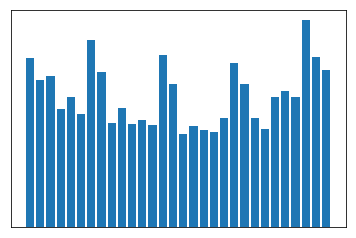

In [14]:
hhh = op_test['day'].value_counts().reset_index().sort_values(by='index')
X = np.array(hhh['index'])
Y1 = np.array(hhh['day'])
# Y2 = np.log(np.array(op1))

plt.bar(X, +Y1)
# plt.bar(X, -Y2)

# plt.xlim(1, 30)
plt.xticks(())
# plt.ylim(-1.25, 1.25)
plt.yticks(())

plt.show()

In [15]:
X

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

## Trans

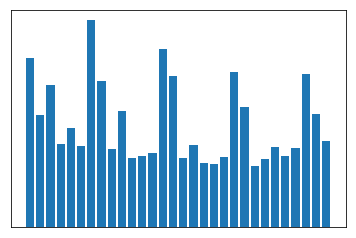

In [16]:
hhh = trans_test['day'].value_counts().reset_index().sort_values(by='index')
X = np.array(hhh['index'])
Y1 = np.array(hhh['day'])
# Y2 = np.log(np.array(op1))

plt.bar(X, +Y1)
# plt.bar(X, -Y2)

# plt.xlim(1, 30)
plt.xticks(())
# plt.ylim(-1.25, 1.25)
plt.yticks(())

plt.show()

# Feature Dictionary

In [240]:
op_all = pd.concat([op_train, op_dev, op_test])
trans_all = pd.concat([trans_train, trans_dev, trans_test])

In [12]:
feature_dic = defaultdict(lambda: defaultdict(list))#[feature,feature_value]
op_key = ['device_code1', 'device_code2', 'device_code3', 'mac1',
'ip1','geo_code','ip1_sub','mac2', 'ip2', 'wifi', 'ip2_sub']
trans_key = ['device_code1','device_code2', 'device_code3',  'mac1', 'ip1',
'geo_code', 'ip1_sub',  'merchant','code1', 'code2', 'acc_id1', 
'acc_id2', 'acc_id3']

In [13]:
for feature in op_key:
    for feature_value, subdf in op_all.groupby([feature]):
        feature_dic[feature][feature_value] += list(subdf['UID'].unique())
        feature_dic[feature][feature_value] = list(set(feature_dic[feature][feature_value]))
for feature in trans_key:
    for feature_value, subdf in trans_all.groupby([feature]):
        feature_dic[feature][feature_value] += list(subdf['UID'].unique())
        feature_dic[feature][feature_value] = list(set(feature_dic[feature][feature_value]))

In [14]:
import gc

In [327]:
gc.collect()

21488

In [326]:
del op_all
del trans_all
gc.collect()

NameError: name 'op_train_with_label' is not defined

## Extra Merge

In [15]:
for feature in ['acc_id1', 'acc_id2', 'acc_id3']:
    for feature_value, subdf in trans_all.groupby([feature]):
        feature_dic['acc_id'][feature_value] += list(subdf['UID'].unique())
        feature_dic['acc_id'][feature_value] = list(set(feature_dic['acc_id'][feature_value]))

In [16]:
for feature in ['device_code1', 'device_code2', 'device_code3']:
    for feature_value, subdf in trans_all.groupby([feature]):
        feature_dic['device_code'][feature_value+feature[-1]] += list(subdf['UID'].unique())
        feature_dic['device_code'][feature_value+feature[-1]] \
        = list(set(feature_dic['device_code'][feature_value+feature[-1]]))

# Feature Engineering

## Basic Feature

In [ ]:
def get_baseline_feature(op,trans,label):
    for feature in op.columns[2:]:
        label = label.merge(op.groupby(['UID'])[feature].count().reset_index(),on='UID',how='left')
        label =label.merge(op.groupby(['UID'])[feature].nunique().reset_index(),on='UID',how='left')
    
    for feature in trans.columns[2:]:
        if trans_train[feature].dtype == 'object':
            label =label.merge(trans.groupby(['UID'])[feature].count().reset_index(),on='UID',how='left')
            label =label.merge(trans.groupby(['UID'])[feature].nunique().reset_index(),on='UID',how='left')
        else:
            label =label.merge(trans.groupby(['UID'])[feature].count().reset_index(),on='UID',how='left')
            label =label.merge(trans.groupby(['UID'])[feature].nunique().reset_index(),on='UID',how='left')
            label =label.merge(trans.groupby(['UID'])[feature].max().reset_index(),on='UID',how='left')
            label =label.merge(trans.groupby(['UID'])[feature].min().reset_index(),on='UID',how='left')
            label =label.merge(trans.groupby(['UID'])[feature].sum().reset_index(),on='UID',how='left')
            label =label.merge(trans.groupby(['UID'])[feature].mean().reset_index(),on='UID',how='left')
            label =label.merge(trans.groupby(['UID'])[feature].std().reset_index(),on='UID',how='left')
    return label

In [110]:
def process_day_seq(seq):
    if len(seq)<2:
        return np.nan
    seq.sort()
    gap = []
    for i in range(len(seq)-1):
        gap.append(seq[i+1]-seq[i])
    return np.array(gap)

def get_modified_feature(op,trans,label):
    op_group = op.groupby(['UID'])
    trans_group = trans.groupby(['UID'])
    for feature in op.columns[1:]:
        op_group_f = op_group[feature]
        label = label.merge(op_group_f.count().reset_index().rename(columns={feature:(feature+'_count')}),on='UID',how='left')
        label =label.merge(op_group_f.nunique().reset_index().rename(columns={feature:(feature+'_nunique')}),on='UID',how='left')
        if feature == 'time':
            label =label.merge(op_group_f.max().reset_index().rename(columns={feature:(feature+'_max')}),on='UID',how='left')
            label =label.merge(op_group_f.min().reset_index().rename(columns={feature:(feature+'_min')}),on='UID',how='left')
            label =label.merge(op_group_f.sum().reset_index().rename(columns={feature:(feature+'_sum')}),on='UID',how='left')
            label =label.merge(op_group_f.mean().reset_index().rename(columns={feature:(feature+'_mean')}),on='UID',how='left')
            label =label.merge(op_group_f.std().reset_index().rename(columns={feature:(feature+'_std')}),on='UID',how='left')
        if feature == 'day':
            tmp = op_group_f.unique().reset_index()
            tmp['day'] = tmp['day'].map(lambda x:process_day_seq(x))
            tmp['max_gap'] = tmp['day'].map(lambda x:np.max(x))
            tmp['min_gap'] = tmp['day'].map(lambda x:np.min(x))
            tmp['mean_gap'] = tmp['day'].map(lambda x:np.mean(x))
            tmp['std_gap'] = tmp['day'].map(lambda x:np.std(x))
            tmp = tmp.drop(['day'], axis=1)
            label = label.merge(tmp, on='UID',how='left')
            tmp2 = op_group_f.value_counts().rename('day_cnt').reset_index().groupby(['UID'])['day_cnt']
            label = label.merge(tmp2.max().reset_index().rename(columns={'day_cnt':'day_cnt_max'}), on='UID',how='left')
            label = label.merge(tmp2.min().reset_index().rename(columns={'day_cnt':'day_cnt_min'}), on='UID',how='left')
            label = label.merge(tmp2.mean().reset_index().rename(columns={'day_cnt':'day_cnt_mean'}), on='UID',how='left')
            label = label.merge(tmp2.std().reset_index().rename(columns={'day_cnt':'day_cnt_std'}), on='UID',how='left')
    for feature in trans.columns[1:]:
        trans_group_f = trans_group[feature]
        if trans[feature].dtype == 'object':
            label =label.merge(trans_group_f.count().reset_index().rename(columns={feature:(feature+'_count')}),on='UID',how='left')
            label =label.merge(trans_group_f.nunique().reset_index().rename(columns={feature:(feature+'_nunique')}),on='UID',how='left')
        else:
            label =label.merge(trans_group_f.count().reset_index().rename(columns={feature:(feature+'_count')}),on='UID',how='left')
            label =label.merge(trans_group_f.nunique().reset_index().rename(columns={feature:(feature+'_nunique')}),on='UID',how='left')
            label =label.merge(trans_group_f.max().reset_index().rename(columns={feature:(feature+'_max')}),on='UID',how='left')
            label =label.merge(trans_group_f.min().reset_index().rename(columns={feature:(feature+'_min')}),on='UID',how='left')
            label =label.merge(trans_group_f.sum().reset_index().rename(columns={feature:(feature+'_sum')}),on='UID',how='left')
            label =label.merge(trans_group_f.mean().reset_index().rename(columns={feature:(feature+'_mean')}),on='UID',how='left')
            label =label.merge(trans_group_f.std().reset_index().rename(columns={feature:(feature+'_std')}),on='UID',how='left')
            if feature == 'day':
                tmp = trans_group_f.unique().reset_index()
                tmp['day'] = tmp['day'].map(lambda x:process_day_seq(x))
                tmp['T_max_gap'] = tmp['day'].map(lambda x:np.max(x))
                tmp['T_min_gap'] = tmp['day'].map(lambda x:np.min(x))
                tmp['T_mean_gap'] = tmp['day'].map(lambda x:np.mean(x))
                tmp['T_std_gap'] = tmp['day'].map(lambda x:np.std(x))
                tmp = tmp.drop(['day'], axis=1)
                label = label.merge(tmp, on='UID',how='left')
                tmp2 = trans_group_f.value_counts().rename('day_cnt').reset_index().groupby(['UID'])['day_cnt']
                label = label.merge(tmp2.max().reset_index().rename(columns={'day_cnt':'T_day_cnt_max'}), on='UID',how='left')
                label = label.merge(tmp2.min().reset_index().rename(columns={'day_cnt':'T_day_cnt_min'}), on='UID',how='left')
                label = label.merge(tmp2.mean().reset_index().rename(columns={'day_cnt':'T_day_cnt_mean'}), on='UID',how='left')
                label = label.merge(tmp2.std().reset_index().rename(columns={'day_cnt':'T_day_cnt_std'}), on='UID',how='left')
    return label

In [27]:
basic_train = pd.read_csv('../feature/train_baseline_m_feature.csv')
basic_test = get_modified_feature(op_test,trans_test, sub)
basic_train[['day_count_x','day_count_y']] = basic_train[['day_count_x','day_count_y']].fillna(0)
basic_test[['day_count_x','day_count_y']] = basic_test[['day_count_x','day_count_y']].fillna(0)
basic_train['trans/op'] = basic_train['day_count_y']/(basic_train['day_count_x']+1)
basic_test['trans/op'] = basic_test['day_count_y']/(basic_test['day_count_x']+1)

In [236]:
basic_train = basic_train.drop(['Tag'], axis=1)

In [239]:
basic_train.to_csv('../feature2/train_baseline_m_feature.csv', index = False)
basic_test.to_csv('../feature2/test_baseline_m_feature.csv', index = False)

In [17]:
basic_train = pd.read_csv('../feature2/train_baseline_m_feature.csv')
basic_test = pd.read_csv('../feature2/test_baseline_m_feature.csv')

## Time Window Feature

In [111]:
def workday_day_cnt(seq, weekends):
    return len(seq)-len(set(seq) & set(weekends))
def weekend_day_cnt(seq,weekends):
    return len(set(seq) & set(weekends))

def get_time_window_feature(op, trans, label, is_train):
    if is_train:
        weekends = [1,2,8,9,15,16,22,23,29,30]
    else:
        weekends = [6,7,13,14,20,21,27,28]#[1,7,8,14,15,21,22,28,29]
    op_group = op.groupby('UID')
    trans_group = trans.groupby('UID')
    #OP
    op_group_f = op_group['day']
    tmp = op_group_f.unique().reset_index()
    tmp['workday_cnt'] = tmp['day'].map(lambda x:workday_day_cnt(x,weekends)) 
    tmp['weekend_day_cnt'] = tmp['day'].map(lambda x:weekend_day_cnt(x,weekends))
    tmp = tmp.drop(['day'], axis=1)
    label = label.merge(tmp, on='UID',how='left')
    
    op_workday = op[~(op['day'].isin(weekends))]    
    tmp2 = op_workday.groupby('UID')['day'].value_counts().rename('day_cnt').reset_index().groupby(['UID'])['day_cnt']
    label = label.merge(tmp2.max().reset_index().rename(columns={'day_cnt':'workday_day_cnt_max'}), on='UID',how='left')
    label = label.merge(tmp2.min().reset_index().rename(columns={'day_cnt':'workday_day_cnt_min'}), on='UID',how='left')
    label = label.merge(tmp2.mean().reset_index().rename(columns={'day_cnt':'workday_day_cnt_mean'}), on='UID',how='left')
    label = label.merge(tmp2.std().reset_index().rename(columns={'day_cnt':'workday_day_cnt_std'}), on='UID',how='left')
    label = label.merge(tmp2.sum().reset_index().rename(columns={'day_cnt':'workday_day_cnt_sum'}), on='UID',how='left')
    
    op_weekend = op[op['day'].isin(weekends)]    
    tmp2 = op_weekend.groupby('UID')['day'].value_counts().rename('day_cnt').reset_index().groupby(['UID'])['day_cnt']
    label = label.merge(tmp2.max().reset_index().rename(columns={'day_cnt':'weekend_day_cnt_max'}), on='UID',how='left')
    label = label.merge(tmp2.min().reset_index().rename(columns={'day_cnt':'weekend_day_cnt_min'}), on='UID',how='left')
    label = label.merge(tmp2.mean().reset_index().rename(columns={'day_cnt':'weekend_day_cnt_mean'}), on='UID',how='left')
    label = label.merge(tmp2.std().reset_index().rename(columns={'day_cnt':'weekend_day_cnt_std'}), on='UID',how='left')
    label = label.merge(tmp2.sum().reset_index().rename(columns={'day_cnt':'weekend_day_cnt_sum'}), on='UID',how='left')
    
    label = label.fillna(0)
    label['workday/weekend_mean'] = label['workday_day_cnt_mean']/(label['weekend_day_cnt_mean'] + 1)
    label['workday/weekend'] = label['workday_day_cnt_sum']/(label['weekend_day_cnt_sum'] + 1)
    
    #TRANS
    trans_group_f = trans_group['day']
    tmp = trans_group_f.unique().reset_index()
    tmp['workday_cnt'] = tmp['day'].map(lambda x:workday_day_cnt(x,weekends)) 
    tmp['weekend_day_cnt'] = tmp['day'].map(lambda x:weekend_day_cnt(x,weekends))
    tmp = tmp.drop(['day'], axis=1)
    label = label.merge(tmp, on='UID',how='left')
    
    trans_workday = trans[~(trans['day'].isin(weekends))]    
    tmp2 = trans_workday.groupby('UID')['day'].value_counts().rename('day_cnt').reset_index().groupby(['UID'])['day_cnt']
    label = label.merge(tmp2.max().reset_index().rename(columns={'day_cnt':'T_workday_day_cnt_max'}), on='UID',how='left')
    label = label.merge(tmp2.min().reset_index().rename(columns={'day_cnt':'T_workday_day_cnt_min'}), on='UID',how='left')
    label = label.merge(tmp2.mean().reset_index().rename(columns={'day_cnt':'T_workday_day_cnt_mean'}), on='UID',how='left')
    label = label.merge(tmp2.std().reset_index().rename(columns={'day_cnt':'T_workday_day_cnt_std'}), on='UID',how='left')
    label = label.merge(tmp2.sum().reset_index().rename(columns={'day_cnt':'T_workday_day_cnt_sum'}), on='UID',how='left')
    
    trans_weekend = trans[trans['day'].isin(weekends)]
    tmp2 = trans_weekend.groupby('UID')['day'].value_counts().rename('day_cnt').reset_index().groupby(['UID'])['day_cnt']
    label = label.merge(tmp2.max().reset_index().rename(columns={'day_cnt':'T_weekend_day_cnt_max'}), on='UID',how='left')
    label = label.merge(tmp2.min().reset_index().rename(columns={'day_cnt':'T_weekend_day_cnt_min'}), on='UID',how='left')
    label = label.merge(tmp2.mean().reset_index().rename(columns={'day_cnt':'T_weekend_day_cnt_mean'}), on='UID',how='left')
    label = label.merge(tmp2.std().reset_index().rename(columns={'day_cnt':'T_weekend_day_cnt_std'}), on='UID',how='left')
    label = label.merge(tmp2.sum().reset_index().rename(columns={'day_cnt':'T_weekend_day_cnt_sum'}), on='UID',how='left')
    
    label = label.fillna(0)
    label['T_workday/weekend_mean'] = label['T_workday_day_cnt_mean']/(label['T_weekend_day_cnt_mean'] + 1)
    label['T_workday/weekend'] = label['T_workday_day_cnt_sum']/(label['T_weekend_day_cnt_sum'] + 1)
    
    return label

In [157]:
# def workday_day_cnt(seq, weekends):
#     return len(seq)-len(set(seq) & set(weekends))
# def weekend_day_cnt(seq,weekends):
#     return len(set(seq) & set(weekends))

# def get_time_window_feature(op, trans, label, is_train):
#     if is_train:
#         weekends = [1,2,8,9,15,16,22,23,29,30]
#     else:
#         weekends = [1,7,8,14,15,21,22,28,29]#[6,7,13,14,20,21,27,28]
#     op_group = op.groupby('UID')
#     trans_group = trans.groupby('UID')
#     #OP
#     op_group_f = op_group['day']
#     tmp = op_group_f.unique().reset_index()
#     tmp['workday_cnt'] = tmp['day'].map(lambda x:workday_day_cnt(x,weekends)) 
#     tmp['weekend_day_cnt'] = tmp['day'].map(lambda x:weekend_day_cnt(x,weekends))
#     tmp = tmp.drop(['day'], axis=1)
#     label = label.merge(tmp, on='UID',how='left')
    
#     op_workday = op[~(op['day'].isin(weekends))]    
#     tmp2 = op_workday.groupby('UID')['day'].value_counts().rename('day_cnt').reset_index().groupby(['UID'])['day_cnt']
#     label = label.merge(tmp2.max().reset_index().rename(columns={'day_cnt':'workday_day_cnt_max'}), on='UID',how='left')
#     label = label.merge(tmp2.min().reset_index().rename(columns={'day_cnt':'workday_day_cnt_min'}), on='UID',how='left')
#     label = label.merge(tmp2.mean().reset_index().rename(columns={'day_cnt':'workday_day_cnt_mean'}), on='UID',how='left')
#     label = label.merge(tmp2.std().reset_index().rename(columns={'day_cnt':'workday_day_cnt_std'}), on='UID',how='left')
#     label = label.merge(tmp2.sum().reset_index().rename(columns={'day_cnt':'workday_day_cnt_sum'}), on='UID',how='left')
    
#     op_weekend = op[op['day'].isin(weekends)]    
#     tmp2 = op_weekend.groupby('UID')['day'].value_counts().rename('day_cnt').reset_index().groupby(['UID'])['day_cnt']
#     label = label.merge(tmp2.max().reset_index().rename(columns={'day_cnt':'weekend_day_cnt_max'}), on='UID',how='left')
#     label = label.merge(tmp2.min().reset_index().rename(columns={'day_cnt':'weekend_day_cnt_min'}), on='UID',how='left')
#     label = label.merge(tmp2.mean().reset_index().rename(columns={'day_cnt':'weekend_day_cnt_mean'}), on='UID',how='left')
#     label = label.merge(tmp2.std().reset_index().rename(columns={'day_cnt':'weekend_day_cnt_std'}), on='UID',how='left')
#     label = label.merge(tmp2.sum().reset_index().rename(columns={'day_cnt':'weekend_day_cnt_sum'}), on='UID',how='left')
    
#     #TRANS
#     trans_group_f = trans_group['day']
#     tmp = trans_group_f.unique().reset_index()
#     tmp['workday_cnt'] = tmp['day'].map(lambda x:workday_day_cnt(x,weekends)) 
#     tmp['weekend_day_cnt'] = tmp['day'].map(lambda x:weekend_day_cnt(x,weekends))
#     tmp = tmp.drop(['day'], axis=1)
#     label = label.merge(tmp, on='UID',how='left')
    
#     trans_workday = trans[~(trans['day'].isin(weekends))]    
#     tmp2 = trans_workday.groupby('UID')['day'].value_counts().rename('day_cnt').reset_index().groupby(['UID'])['day_cnt']
#     label = label.merge(tmp2.max().reset_index().rename(columns={'day_cnt':'workday_day_cnt_max'}), on='UID',how='left')
#     label = label.merge(tmp2.min().reset_index().rename(columns={'day_cnt':'workday_day_cnt_min'}), on='UID',how='left')
#     label = label.merge(tmp2.mean().reset_index().rename(columns={'day_cnt':'workday_day_cnt_mean'}), on='UID',how='left')
#     label = label.merge(tmp2.std().reset_index().rename(columns={'day_cnt':'workday_day_cnt_std'}), on='UID',how='left')
    
    
#     trans_weekend = trans[trans['day'].isin(weekends)]
#     tmp2 = trans_weekend.groupby('UID')['day'].value_counts().rename('day_cnt').reset_index().groupby(['UID'])['day_cnt']
#     label = label.merge(tmp2.max().reset_index().rename(columns={'day_cnt':'weekend_day_cnt_max'}), on='UID',how='left')
#     label = label.merge(tmp2.min().reset_index().rename(columns={'day_cnt':'weekend_day_cnt_min'}), on='UID',how='left')
#     label = label.merge(tmp2.mean().reset_index().rename(columns={'day_cnt':'weekend_day_cnt_mean'}), on='UID',how='left')
#     label = label.merge(tmp2.std().reset_index().rename(columns={'day_cnt':'weekend_day_cnt_std'}), on='UID',how='left')
    
#     return label

In [140]:
tw_train = get_time_window_feature(op_train, trans_train, y, True)
tw_test = get_time_window_feature(op_test, trans_test, sub, False)
tw_train = tw_train.drop(['Tag'], axis=1)
tw_test = tw_test.drop(['Tag'], axis=1)

In [230]:
tw_train.to_csv('../feature2/train_tw_feature.csv',index=False)
tw_test.to_csv('../feature2/test_tw_feature.csv',index=False)

In [18]:
tw_train = pd.read_csv('../feature2/train_tw_feature.csv')
tw_test = pd.read_csv('../feature2/test_tw_feature.csv')

## Day Granulity Feature

In [19]:
def get_day_feature(op_raw, trans_raw, label):
    op = op_raw.fillna(-1)
    trans = trans_raw.fillna(-1)
    print('OP begin...')
    f_u_dic = defaultdict(lambda: defaultdict(int))#dict[feature][u] = value
    for u, subdf in op.groupby('UID'):
        f_dic = defaultdict(list)#[feature] = list
        for day, subdf2 in subdf.groupby('day'):
            tmp = subdf2.groupby(subdf2['time'].map(lambda x:int(x)))['time'].count()
            hour_max = tmp.max()
            f_dic['dense_times'].append(hour_max)
            hour = tmp.argmax()
            n_hour = tmp.shape[0]
            f_dic['nunique_hour'].append(n_hour)
            gap = subdf2[subdf2['time'].map(lambda x:int(x))==hour]['time'].max() \
            - subdf2[subdf2['time'].map(lambda x:int(x))==hour]['time'].min()
            if gap==0:
                op_f = 0
            else:
                op_f = (hour_max-1)/gap
            f_dic['op/h'].append(op_f)
            for feature in op.columns[2:]:
                if feature == 'time':
                    continue
                f_dic[feature+'_nunique'] = subdf2[feature].nunique()
                f_dic[feature+'_nunique/t'] = subdf2[feature].nunique()/n_hour

        f_u_dic['max_day_dense_times'][u] = np.max(f_dic['dense_times'])
        f_u_dic['mean_day_dense_times'][u] = np.mean(f_dic['dense_times'])
        f_u_dic['std_day_dense_times'][u] = np.std(f_dic['dense_times'])

        f_u_dic['max_day_nunique_hour'][u] = np.max(f_dic['nunique_hour'])
        f_u_dic['mean_day_nunique_hour'][u] = np.mean(f_dic['nunique_hour'])
        f_u_dic['std_day_nunique_hour'][u] = np.std(f_dic['nunique_hour'])

        f_u_dic['max_day_op/h'][u] = np.max(f_dic['op/h'])
        f_u_dic['mean_day_op/h'][u] = np.mean(f_dic['op/h'])
        f_u_dic['std_day_op/h'][u] = np.std(f_dic['op/h'])

        for feature in op.columns[2:]:
            if feature == 'time':
                continue
            f_u_dic['max_day_'+feature+'_nunique'][u] = np.max(f_dic[feature+'_nunique'])
            f_u_dic['mean_day_'+feature+'_nunique'][u] = np.mean(f_dic[feature+'_nunique'])
            f_u_dic['std_day_'+feature+'_nunique'][u] = np.std(f_dic[feature+'_nunique'])

            f_u_dic['max_day_'+feature+'_nunique/t'][u] = np.max(f_dic[feature+'_nunique/t'])
            f_u_dic['mean_day_'+feature+'_nunique/t'][u] = np.mean(f_dic[feature+'_nunique/t'])
            f_u_dic['std_day_'+feature+'_nunique/t'][u] = np.std(f_dic[feature+'_nunique/t'])
    for feature in f_u_dic.keys():
        uuu = []
        fff = []
        for u, v in f_u_dic[feature].items():
            uuu.append(u)
            fff.append(v)
        label = label.merge(pd.DataFrame({'UID':uuu, feature:fff}), on='UID', how='left')
    
    print('TRANS begin...')
    f_u_dic = defaultdict(lambda: defaultdict(int))#dict[feature][u] = value
    for u, subdf in trans.groupby('UID'):
        f_dic = defaultdict(list)#[feature] = list
        for day, subdf2 in subdf.groupby('day'):
            tmp = subdf2.groupby(subdf2['time'].map(lambda x:int(x)))['time'].count()
            hour_max = tmp.max()
            f_dic['dense_times'].append(hour_max)
            hour = tmp.argmax()
            n_hour = tmp.shape[0]
            f_dic['nunique_hour'].append(n_hour)
            gap = subdf2[subdf2['time'].map(lambda x:int(x))==hour]['time'].max() \
            - subdf2[subdf2['time'].map(lambda x:int(x))==hour]['time'].min()
            if gap==0:
                trans_f = 0
            else:
                trans_f = (hour_max-1)/gap
            f_dic['trans/h'].append(trans_f)
            
            f_dic['mean_day_trans_amt'].append(subdf2['trans_amt'].mean())
            
            for feature in trans.columns[1:]:
                if feature in ['time', 'day']:
                    continue
                f_dic[feature+'_nunique'] = subdf2[feature].nunique()
                f_dic[feature+'_nunique/t'] = subdf2[feature].nunique()/n_hour

        f_u_dic['max_day_dense_times'][u] = np.max(f_dic['dense_times'])
        f_u_dic['mean_day_dense_times'][u] = np.mean(f_dic['dense_times'])
        f_u_dic['std_day_dense_times'][u] = np.std(f_dic['dense_times'])

        f_u_dic['max_day_nunique_hour'][u] = np.max(f_dic['nunique_hour'])
        f_u_dic['mean_day_nunique_hour'][u] = np.mean(f_dic['nunique_hour'])
        f_u_dic['std_day_nunique_hour'][u] = np.std(f_dic['nunique_hour'])

        f_u_dic['max_day_trans/h'][u] = np.max(f_dic['trans/h'])
        f_u_dic['mean_day_trans/h'][u] = np.mean(f_dic['trans/h'])
        f_u_dic['std_day_trans/h'][u] = np.std(f_dic['trans/h'])
        
        freq_amt = subdf.groupby('trans_amt')['trans_amt'].count().argmax()
        f_u_dic['most_freq_trans_amt'][u] = freq_amt
        f_u_dic['trans_amt_102_cnt'][u] = subdf[subdf['trans_amt']==102].shape[0]
        f_u_dic['trans_amt_2818_cnt'][u] = subdf[subdf['trans_amt']==2818].shape[0]
        f_u_dic['trans_amt_1459_cnt'][u] = subdf[subdf['trans_amt']==1459].shape[0]
        
        for feature in trans.columns[1:]:
            if feature in ['time', 'day']:
                continue
            f_u_dic['max_day_'+feature+'_nunique'][u] = np.max(f_dic[feature+'_nunique'])
            f_u_dic['mean_day_'+feature+'_nunique'][u] = np.mean(f_dic[feature+'_nunique'])
            f_u_dic['std_day_'+feature+'_nunique'][u] = np.std(f_dic[feature+'_nunique'])

            f_u_dic['max_day_'+feature+'_nunique/t'][u] = np.max(f_dic[feature+'_nunique/t'])
            f_u_dic['mean_day_'+feature+'_nunique/t'][u] = np.mean(f_dic[feature+'_nunique/t'])
            f_u_dic['std_day_'+feature+'_nunique/t'][u] = np.std(f_dic[feature+'_nunique/t'])
    for feature in f_u_dic.keys():
        uuu = []
        fff = []
        for u, v in f_u_dic[feature].items():
            uuu.append(u)
            fff.append(v)
        label = label.merge(pd.DataFrame({'UID':uuu, ('T_'+feature):fff}), on='UID', how='left')
    return label

In [20]:
day_train = get_day_feature(op_train.fillna(-1), trans_train.fillna(-1), y)
day_test = get_day_feature(op_test.fillna(-1), trans_test.fillna(-1), sub)
day_train = day_train.drop(['Tag'], axis=1)
day_test = day_test.drop(['Tag'], axis=1)

OP begin...
TRANS begin...
OP begin...
TRANS begin...


ValueError: labels ['Tag'] not contained in axis

In [21]:
day_train.to_csv('../feature2/train_day_feature.csv',index=False)
day_test.to_csv('../feature2/test_day_feature.csv',index=False)

In [ ]:
day_train = pd.read_csv('../feature2/train_day_feature.csv')
day_test = pd.read_csv('../feature2/test_day_feature.csv')

## Static and Neighbor Feature

In [22]:
mode_1 = ['08017d2cb28c2348', '270ca3ca8f0d1126',
'2e6fdb7d4ddef57f', '2f3e878175e34d9c',
'ac63e881c4e19402', 'd25caee90b27fa9b',
'8c7ce5ff939e66d1', '8e463287d7146285',
'963bd8a75ff9ab37', '9c69742a831d6214']
mode_2 = ['79f8b86938180c3c']
mode_3 = ['acfaded7e04e7ba0']
mode_4 = ['9faf791e291fe4a1','a3f0d631c4fcaf38',
'a698c1862f390021', 'e00efcf34eb17f69',
'2e7e5808ff6323e8', '385608c64026c669',
'8b259df485199a2b']

version_1 = ['4.1.7','6.1.0',
'6.5.0','6.6.3','7.0.0']
version_2 = ['7.0.7']

# 记得加上整合feature ！！！
op_feature = ['mac2','ip2','wifi', 'ip2_sub']
trans_feature = ['merchant', 'code1', 'code2', 'acc_id1', 
'acc_id2', 'acc_id3', 'acc_id']#'trans_amt', 
common_feature = ['device_code1','device_code2', 'device_code3', 'mac1', 'ip1',
'geo_code', 'ip1_sub']#device_code

In [23]:
def get_op_feature(op):
    uid = []

    md1 = []
    md2 = []
    md3 = []
    md4 = []
    md_res = []

    vr1 = []
    vr2 = []
    vr_res = []

    os_list = []
    for i in range(7):
        os_list.append([])
        
    feature_list = defaultdict(list)

    for u, subdf in op.groupby(['UID']):
        uid.append(u)
        #mode feature
        mode1_cnt = 0
        mode2_cnt = 0
        mode3_cnt = 0
        mode4_cnt = 0
        mode_res_cnt = 0
        tmp = subdf['mode'].value_counts()
        for idx in tmp.index:
            if idx in mode_1:
                mode1_cnt += tmp.loc[idx]
            elif idx in mode_2:
                mode2_cnt += tmp.loc[idx]
            elif idx in mode_3:
                mode3_cnt += tmp.loc[idx]
            elif idx in mode_4:
                mode4_cnt += tmp.loc[idx]
            else:
                mode_res_cnt += tmp.loc[idx]
        md1.append(mode1_cnt)
        md2.append(mode2_cnt)
        md3.append(mode3_cnt)
        md4.append(mode4_cnt)
        md_res.append(mode_res_cnt)

        #version feature
        v1_cnt = 0
        v2_cnt = 0
        v_res_cnt = 0
        tmp = subdf['version'].value_counts()
        for idx in tmp.index:
            if idx in version_1:
                v1_cnt += tmp.loc[idx]
            elif idx in version_2:
                v2_cnt += tmp.loc[idx]
            else:
                v_res_cnt += tmp.loc[idx]
        vr1.append(v1_cnt)
        vr2.append(v2_cnt)
        vr_res.append(v_res_cnt)

        #os feature
        os_cnt = []
        for i in range(7):
            os_cnt.append(0)
        tmp = subdf['os'].unique().tolist()
        for idx in tmp:
            if idx==101:
                os_cnt[0]=1
            elif idx==102:
                os_cnt[1]=1
            elif idx==103:
                os_cnt[2]=1
            elif idx==104:
                os_cnt[3]=1
            elif idx==105:
                os_cnt[4]=1
            elif idx==107:
                os_cnt[5]=1
            elif idx==200:
                os_cnt[6]=1
        for i in range(7):
            os_list[i].append(os_cnt[i])
        #other op feature
        for feature in op_feature:
            values = subdf[feature].unique().tolist()
            result = set()
            for value in values:
                l = feature_dic[feature][value].copy()
                l = set(l)-{u}
                result = result | l
            feature_list[feature+'_neighbor_cnt'].append(len(result))
    fff = pd.DataFrame({'UID':uid, 'mode1_cnt':md1, 'mode2_cnt':md2, 'mode3_cnt':md3,
                             'mode4_cnt':md4, 'mode_res_cnt':md_res, 'version1_cnt':vr1,
                              'version2_cnt':vr2, 'version_res_cnt':vr_res, 'os1_cnt':os_list[0],
                             'os2_cnt':os_list[1],'os3_cnt':os_list[2],'os4_cnt':os_list[3],
                             'os5_cnt':os_list[4],'os6_cnt':os_list[5],'os7_cnt':os_list[6]
                            })
    for feature in op_feature:
        fff[feature+'_neighbor_cnt'] = feature_list[feature+'_neighbor_cnt']
    return fff

In [24]:
def get_trans_feature(trans):
    uid = []
    
    channel = []
    for i in range(5):
        channel.append([])

    tr_2 = []
    for i in range(4):
        tr_2.append([])

    mar1 = []
    mar2 = []   
    
    feature_list = defaultdict(list)

    for u, subdf in trans.groupby(['UID']):
        uid.append(u)
        #channel feature
        ch_cnt = []
        for i in range(5):
            ch_cnt.append(0)
        tmp = subdf['channel'].value_counts()
        for idx in tmp.index:
            if idx == 102:
                ch_cnt[0] += tmp.loc[idx]
            elif idx == 106:
                ch_cnt[1] += tmp.loc[idx]
            elif idx == 118:
                ch_cnt[2] += tmp.loc[idx]
            elif idx == 119:
                ch_cnt[3] += tmp.loc[idx]
            elif idx == 140:
                ch_cnt[4] += tmp.loc[idx]
        for i in range(5):
            channel[i].append(ch_cnt[i])
        #trans_type2 feature
        tr_2_cnt = []
        for i in range(4):
            tr_2_cnt.append(0)
        tmp = subdf['channel'].value_counts()
        for idx in tmp.index:
            if idx == 102:
                tr_2_cnt[0] += tmp.loc[idx]
            elif idx == 103:
                tr_2_cnt[1] += tmp.loc[idx]
            elif idx == 104:
                tr_2_cnt[2] += tmp.loc[idx]
            elif idx == 105:
                tr_2_cnt[3] += tmp.loc[idx]
        for i in range(4):
            tr_2[i].append(tr_2_cnt[i])
        #market_type feature
        mar1_cnt = 0
        mar2_cnt = 0
        tmp = subdf['market_type'].value_counts()
        for idx in tmp.index:
            if idx == 1:
                mar1_cnt += tmp.loc[idx]
            elif idx == 2:
                mar2_cnt += tmp.loc[idx]
        mar1.append(mar1_cnt)
        mar2.append(mar2_cnt)
        
        for feature in trans_feature:
            if feature == 'acc_id':
                values = list(set(subdf['acc_id1'].unique().tolist() \
                + subdf['acc_id2'].unique().tolist() \
                + subdf['acc_id3'].unique().tolist()))
            else:
                values = subdf[feature].unique().tolist()
            result = set()
            for value in values:
                l = feature_dic[feature][value].copy()
                l = set(l)-{u}
                result = result | l
            feature_list[feature+'_neighbor_cnt'].append(len(result))

    fff = pd.DataFrame({'UID':uid, 'market_type_1_cnt':mar1, 'market_type_2_cnt':mar2
                            })
    for i in range(5):
        fff['channel_{}_cnt'.format(i+1)]=channel[i]
    for i in range(4):
        fff['trans_type2_{}_cnt'.format(i+1)]=tr_2[i]
    for feature in trans_feature:
        fff[feature+'_neighbor_cnt'] = feature_list[feature+'_neighbor_cnt']
    return fff

In [25]:
def get_common_feature(op, trans):
    uid = []
    feature_list = defaultdict(list)
    
    tmp = pd.concat([op[common_feature+['UID']],trans[common_feature+['UID']]]).groupby(['UID'])
    for u, subdf in tmp:
        uid.append(u)
        for feature in common_feature+['device_code']:
            if feature == 'device_code':
                values = list(set((subdf['device_code1']+'1').unique().tolist() \
                + (subdf['device_code2']+'2').unique().tolist() \
                + (subdf['device_code3']+'3').unique().tolist()))
            else:
                values = subdf[feature].fillna(-1).unique().tolist()
            result = set()
            for value in values:
                if value == -1:
                    continue
                l = feature_dic[feature][value].copy()
                l = set(l)-{u}
                result = result | l
            feature_list[feature+'_neighbor_cnt'].append(len(result))
    fff = pd.DataFrame({'UID':uid})
    for feature in common_feature+['device_code']:
        fff[feature+'_neighbor_cnt'] = feature_list[feature+'_neighbor_cnt']
    return fff

In [26]:
common_train = get_common_feature(op_train, trans_train)
common_test = get_common_feature(op_test, trans_test)
op_f_train = get_op_feature(op_train)
op_f_test = get_op_feature(op_test)
trans_f_train = get_trans_feature(trans_train)
trans_f_test = get_trans_feature(trans_test)

In [282]:
common_train.describe()

,UID,device_code1_neighbor_cnt,device_code2_neighbor_cnt,device_code3_neighbor_cnt,mac1_neighbor_cnt,ip1_neighbor_cnt,geo_code_neighbor_cnt,ip1_sub_neighbor_cnt,device_code_neighbor_cnt
count,31179.000000,31179.000000,31179.000000,31179.000000,31179.000000,31179.000000,31179.000000,31179.000000,31179.000000
mean,40725.647936,2.692004,1.802816,493.665384,10454.334360,17.415440,204.197665,263.173675,40.389846
std,21386.287959,16.250765,12.325963,3038.931534,15286.004401,62.196074,239.450044,315.102678,232.480327
min,10000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17794.500000,0.000000,0.000000,0.000000,0.000000,0.000000,34.000000,54.000000,0.000000
50%,52167.000000,0.000000,0.000000,0.000000,0.000000,2.000000,114.000000,154.000000,0.000000
75%,59961.500000,0.000000,0.000000,0.000000,32811.000000,9.000000,285.000000,352.000000,0.000000
max,67756.000000,186.000000,176.000000,19260.000000,32963.000000,658.000000,2589.000000,3096.000000,1519.000000


### Save

In [27]:
common_train.to_csv('../feature2/train_common_feature.csv',index=False)
common_test.to_csv('../feature2/test_common_feature.csv',index=False)
op_f_train.to_csv('../feature2/train_op_feature.csv',index=False)
op_f_test.to_csv('../feature2/test_op_feature.csv',index=False)
trans_f_train.to_csv('../feature2/train_trans_feature.csv',index=False)
trans_f_test.to_csv('../feature2/test_trans_feature.csv',index=False)

### Load

In [ ]:
common_train = pd.read_csv('../feature2/train_common_feature.csv')
common_test = pd.read_csv('../feature2/test_common_feature.csv')
op_f_train = pd.read_csv('../feature2/train_op_feature.csv')
op_f_test = pd.read_csv('../feature2/test_op_feature.csv')
trans_f_train = pd.read_csv('../feature2/train_trans_feature.csv')
trans_f_test = pd.read_csv('../feature2/test_trans_feature.csv')

## 2nd Neighbor feature

In [ ]:
def get_common_feature(op, trans):
    uid = []
    feature_list = defaultdict(list)
    
    tmp = pd.concat([op[common_feature+['UID']],trans[common_feature+['UID']]]).groupby(['UID'])
    for u, subdf in tmp:
        uid.append(u)
        for feature in common_feature+['device_code']:
            if feature == 'device_code':
                values = list(set((subdf['device_code1']+'1').unique().tolist() \
                + (subdf['device_code2']+'2').unique().tolist() \
                + (subdf['device_code3']+'3').unique().tolist()))
            else:
                values = subdf[feature].unique().tolist()
            neighbors_1st = set()
            for value in values:
                l = feature_dic[feature][value].copy()
                l = set(l)-{u}
                result = result | l
            feature_list[feature+'_neighbor_cnt'].append(len(result))
    fff = pd.DataFrame({'UID':uid})
    for feature in common_feature+['device_code']:
        fff[feature+'_neighbor_cnt'] = feature_list[feature+'_neighbor_cnt']
    return fff

## Ration Feature

In [152]:
ration_train = pd.read_csv('../feature2/ration_train.csv')
ration_test = pd.read_csv('../feature2/ration_test.csv')
ration_train = ration_train.drop(['Tag'],axis = 1)
ration_test = ration_test.drop(['Tag'],axis = 1)

ValueError: labels ['Tag'] not contained in axis

In [28]:
ration_train_m = pd.read_csv('../feature2/ration_train_m2.csv')
ration_test_m = pd.read_csv('../feature2/ration_test_m2.csv')
ration_train_m = ration_train_m.drop(['Tag'],axis = 1)
ration_test_m = ration_test_m.drop(['Tag'],axis = 1)

ValueError: labels ['Tag'] not contained in axis

In [324]:
ration_train_m.head()

,UID,UIDip1_cnt,UIDip1_nunique,UIDmac1_cnt,UIDmac1_nunique,UIDmac2_cnt,UIDmac2_nunique,UIDgeo_code_cnt,UIDgeo_code_nunique,dayip1_cnt,dayip1_nunique,dayip1_max,dayip1_min,dayip1_sum,dayip1_mean,dayip1_std,daymac1_cnt,daymac1_nunique,daymac1_max,daymac1_min,daymac1_sum,daymac1_mean,daymac1_std,daymac2_cnt,daymac2_nunique,daymac2_max,daymac2_min,daymac2_sum,daymac2_mean,daymac2_std,modeip1_cnt,modeip1_nunique,modemac1_cnt,modemac1_nunique,modemac2_cnt,modemac2_nunique,modegeo_code_cnt,modegeo_code_nunique,successip1_cnt,successip1_nunique,successmac1_cnt,successmac1_nunique,successmac2_cnt,successmac2_nunique,successgeo_code_cnt,successgeo_code_nunique,timeip1_cnt,timeip1_nunique,timemac1_cnt,timemac1_nunique,timemac2_cnt,timemac2_nunique,timegeo_code_cnt,timegeo_code_nunique,osip1_cnt,osip1_nunique,osmac1_cnt,osmac1_nunique,osmac2_cnt,osmac2_nunique,osgeo_code_cnt,osgeo_code_nunique,versionip1_cnt,versionip1_nunique,versionmac1_cnt,versionmac1_nunique,versionmac2_cnt,versionmac2_nunique,versiongeo_code_cnt,versiongeo_code_nunique,device1ip1_cnt,device1ip1_nunique,device1mac1_cnt,device1mac1_nunique,device1mac2_cnt,device1mac2_nunique,device1geo_code_cnt,device1geo_code_nunique,device2ip1_cnt,device2ip1_nunique,device2mac1_cnt,device2mac1_nunique,device2mac2_cnt,device2mac2_nunique,device2geo_code_cnt,device2geo_code_nunique,device_code1ip1_cnt,device_code1ip1_nunique,device_code1mac1_cnt,device_code1mac1_nunique,device_code1mac2_cnt,device_code1mac2_nunique,device_code1geo_code_cnt,device_code1geo_code_nunique,device_code2ip1_cnt,device_code2ip1_nunique,device_code2mac1_cnt,device_code2mac1_nunique,device_code2mac2_cnt,device_code2mac2_nunique,device_code2geo_code_cnt,device_code2geo_code_nunique,device_code3ip1_cnt,device_code3ip1_nunique,device_code3mac1_cnt,device_code3mac1_nunique,device_code3mac2_cnt,device_code3mac2_nunique,device_code3geo_code_cnt,device_code3geo_code_nunique,mac1ip1_cnt,mac1ip1_nunique,mac1mac2_cnt,mac1mac2_nunique,mac1geo_code_cnt,mac1geo_code_nunique,mac2ip1_cnt,mac2ip1_nunique,mac2mac1_cnt,mac2mac1_nunique,mac2geo_code_cnt,mac2geo_code_nunique,ip1mac1_cnt,ip1mac1_nunique,ip1mac2_cnt,ip1mac2_nunique,ip1geo_code_cnt,ip1geo_code_nunique,ip2ip1_cnt,ip2ip1_nunique,ip2mac1_cnt,ip2mac1_nunique,ip2mac2_cnt,ip2mac2_nunique,ip2geo_code_cnt,ip2geo_code_nunique,wifiip1_cnt,wifiip1_nunique,wifimac1_cnt,wifimac1_nunique,wifimac2_cnt,wifimac2_nunique,wifigeo_code_cnt,wifigeo_code_nunique,geo_codeip1_cnt,geo_codeip1_nunique,geo_codemac1_cnt,geo_codemac1_nunique,geo_codemac2_cnt,geo_codemac2_nunique,ip1_subip1_cnt,ip1_subip1_nunique,ip1_submac1_cnt,ip1_submac1_nunique,ip1_submac2_cnt,ip1_submac2_nunique,ip1_subgeo_code_cnt,ip1_subgeo_code_nunique,ip2_subip1_cnt,ip2_subip1_nunique,ip2_submac1_cnt,ip2_submac1_nunique,ip2_submac2_cnt,ip2_submac2_nunique,ip2_subgeo_code_cnt,ip2_subgeo_code_nunique,T_channelmerchant_cnt,T_channelmerchant_nunique,T_channelip1_cnt,T_channelip1_nunique,T_channelmac1_cnt,T_channelmac1_nunique,T_channelgeo_code_cnt,T_channelgeo_code_nunique,T_daymerchant_cnt,T_daymerchant_nunique,T_daymerchant_max,T_daymerchant_min,T_daymerchant_sum,T_daymerchant_mean,T_daymerchant_std,T_dayip1_cnt,T_dayip1_nunique,T_dayip1_max,T_dayip1_min,T_dayip1_sum,T_dayip1_mean,T_dayip1_std,T_daymac1_cnt,T_daymac1_nunique,T_daymac1_max,T_daymac1_min,T_daymac1_sum,T_daymac1_mean,T_daymac1_std,T_timemerchant_cnt,T_timemerchant_nunique,T_timeip1_cnt,T_timeip1_nunique,T_timemac1_cnt,T_timemac1_nunique,T_timegeo_code_cnt,T_timegeo_code_nunique,T_trans_amtmerchant_cnt,T_trans_amtmerchant_nunique,T_trans_amtmerchant_max,T_trans_amtmerchant_min,T_trans_amtmerchant_sum,T_trans_amtmerchant_mean,T_trans_amtmerchant_std,T_trans_amtip1_cnt,T_trans_amtip1_nunique,T_trans_amtip1_max,T_trans_amtip1_min,T_trans_amtip1_sum,T_trans_amtip1_mean,T_trans_amtip1_std,T_trans_amtmac1_cnt,T_trans_amtmac1_nunique,T_trans_amtmac1_max,T_trans_amtmac1_min,T_trans_amtmac1_sum,T_trans_amtmac1_mean,T_trans_amtmac1_std,T_amt_src1merchant_cnt,T_amt_src1me

## Merchant Relevant Feature

In [29]:
def get_merchant_feature(trans, label):
    deliver = ['day', 'merchant']
    for feature in trans.columns[4:]:
        if feature not in ['merchant', 'code1', 'code2']:
            print(feature, 'begin...')
            
            temp = trans[['UID']+deliver+[feature]].drop_duplicates().merge(trans.groupby(deliver+[feature])['UID'].count().reset_index(),on=(deliver+[feature]),how='left')[['UID_x','UID_y']] 
            
            temp1 = temp.groupby('UID_x')['UID_y'].sum().reset_index()
            temp1.columns = ['UID','T_'+feature+'_same_merchant_day'+'_cnt'+'_sum']
            label =label.merge(temp1,on='UID',how='left')
            
            temp1 = temp.groupby('UID_x')['UID_y'].max().reset_index()
            temp1.columns = ['UID','T_'+feature+'_same_merchant_day'+'_cnt'+'_max']
            label =label.merge(temp1,on='UID',how='left')
            
            temp1 = temp.groupby('UID_x')['UID_y'].min().reset_index()
            temp1.columns = ['UID','T_'+feature+'_same_merchant_day'+'_cnt'+'_min']
            label =label.merge(temp1,on='UID',how='left')
            
            temp1 = temp.groupby('UID_x')['UID_y'].mean().reset_index()
            temp1.columns = ['UID','T_'+feature+'_same_merchant_day'+'_cnt'+'_mean']
            label =label.merge(temp1,on='UID',how='left')
            
            temp1 = temp.groupby('UID_x')['UID_y'].std().reset_index()
            temp1.columns = ['UID','T_'+feature+'_same_merchant_day'+'_cnt'+'_std']
            label =label.merge(temp1,on='UID',how='left')
            
            del temp
            del temp1
            
            temp = trans[['UID']+deliver+[feature]].drop_duplicates().merge((trans.groupby(deliver+[feature])['UID'].nunique()-1).reset_index(),on=(deliver+[feature]),how='left')[['UID_x','UID_y']] 
            
            temp1 = temp.groupby('UID_x')['UID_y'].sum().reset_index()
            temp1.columns = ['UID','T_'+feature+'_same_merchant_day'+'_nunique'+'_sum']
            label =label.merge(temp1,on='UID',how='left')
            
            temp1 = temp.groupby('UID_x')['UID_y'].max().reset_index()
            temp1.columns = ['UID','T_'+feature+'_same_merchant_day'+'_nunique'+'_max']
            label =label.merge(temp1,on='UID',how='left')
            
            temp1 = temp.groupby('UID_x')['UID_y'].min().reset_index()
            temp1.columns = ['UID','T_'+feature+'_same_merchant_day'+'_nunique'+'_min']
            label =label.merge(temp1,on='UID',how='left')
            
            temp1 = temp.groupby('UID_x')['UID_y'].mean().reset_index()
            temp1.columns = ['UID','T_'+feature+'_same_merchant_day'+'_nunique'+'_mean']
            label =label.merge(temp1,on='UID',how='left')
            
            temp1 = temp.groupby('UID_x')['UID_y'].std().reset_index()
            temp1.columns = ['UID','T_'+feature+'_same_merchant_day'+'_nunique'+'_std']
            label =label.merge(temp1,on='UID',how='left')
            
            del temp
            del temp1
            
    print("Done")
    return label

In [314]:
merchant_train.head()

,UID,Tag,T_trans_amt_same_merchant_day_cnt_sum,T_trans_amt_same_merchant_day_cnt_max,T_trans_amt_same_merchant_day_cnt_min,T_trans_amt_same_merchant_day_cnt_mean,T_trans_amt_same_merchant_day_cnt_std,T_trans_amt_same_merchant_day_nunique_sum,T_trans_amt_same_merchant_day_nunique_max,T_trans_amt_same_merchant_day_nunique_min,T_trans_amt_same_merchant_day_nunique_mean,T_trans_amt_same_merchant_day_nunique_std,T_amt_src1_same_merchant_day_cnt_sum,T_amt_src1_same_merchant_day_cnt_max,T_amt_src1_same_merchant_day_cnt_min,T_amt_src1_same_merchant_day_cnt_mean,T_amt_src1_same_merchant_day_cnt_std,T_amt_src1_same_merchant_day_nunique_sum,T_amt_src1_same_merchant_day_nunique_max,T_amt_src1_same_merchant_day_nunique_min,T_amt_src1_same_merchant_day_nunique_mean,T_amt_src1_same_merchant_day_nunique_std,T_trans_type1_same_merchant_day_cnt_sum,T_trans_type1_same_merchant_day_cnt_max,T_trans_type1_same_merchant_day_cnt_min,T_trans_type1_same_merchant_day_cnt_mean,T_trans_type1_same_merchant_day_cnt_std,T_trans_type1_same_merchant_day_nunique_sum,T_trans_type1_same_merchant_day_nunique_max,T_trans_type1_same_merchant_day_nunique_min,T_trans_type1_same_merchant_day_nunique_mean,T_trans_type1_same_merchant_day_nunique_std,T_acc_id1_same_merchant_day_cnt_sum,T_acc_id1_same_merchant_day_cnt_max,T_acc_id1_same_merchant_day_cnt_min,T_acc_id1_same_merchant_day_cnt_mean,T_acc_id1_same_merchant_day_cnt_std,T_acc_id1_same_merchant_day_nunique_sum,T_acc_id1_same_merchant_day_nunique_max,T_acc_id1_same_merchant_day_nunique_min,T_acc_id1_same_merchant_day_nunique_mean,T_acc_id1_same_merchant_day_nunique_std,T_device_code1_same_merchant_day_cnt_sum,T_device_code1_same_merchant_day_cnt_max,T_device_code1_same_merchant_day_cnt_min,T_device_code1_same_merchant_day_cnt_mean,T_device_code1_same_merchant_day_cnt_std,T_device_code1_same_merchant_day_nunique_sum,T_device_code1_same_merchant_day_nunique_max,T_device_code1_same_merchant_day_nunique_min,T_device_code1_same_merchant_day_nunique_mean,T_device_code1_same_merchant_day_nunique_std,T_device_code2_same_merchant_day_cnt_sum,T_device_code2_same_merchant_day_cnt_max,T_device_code2_same_merchant_day_cnt_min,T_device_code2_same_merchant_day_cnt_mean,T_device_code2_same_merchant_day_cnt_std,T_device_code2_same_merchant_day_nunique_sum,T_device_code2_same_merchant_day_nunique_max,T_device_code2_same_merchant_day_nunique_min,T_device_code2_same_merchant_day_nunique_mean,T_device_code2_same_merchant_day_nunique_std,T_device_code3_same_merchant_day_cnt_sum,T_device_code3_same_merchant_day_cnt_max,T_device_code3_same_merchant_day_cnt_min,T_device_code3_same_merchant_day_cnt_mean,T_device_code3_same_merchant_day_cnt_std,T_device_code3_same_merchant_day_nunique_sum,T_device_code3_same_merchant_day_nunique_max,T_device_code3_same_merchant_day_nunique_min,T_device_code3_same_merchant_day_nunique_mean,T_device_code3_same_merchant_day_nunique_std,T_device1_same_merchant_day_cnt_sum,T_device1_same_merchant_day_cnt_max,T_device1_same_merchant_day_cnt_min,T_device1_same_merchant_day_cnt_mean,T_device1_same_merchant_day_cnt_std,T_device1_same_merchant_day_nunique_sum,T_device1_same_merchant_day_nunique_max,T_device1_same_merchant_day_nunique_min,T_device1_same_merchant_day_nunique_mean,T_device1_same_merchant_day_nunique_std,T_device2_same_merchant_day_cnt_sum,T_device2_same_merchant_day_cnt_max,T_device2_same_merchant_day_cnt_min,T_device2_same_merchant_day_cnt_mean,T_device2_same_merchant_day_cnt_std,T_device2_same_merchant_day_nunique_sum,T_device2_same_merchant_day_nunique_max,T_device2_same_merchant_day_nunique_min,T_device2_same_merchant_day_nunique_mean,T_device2_same_merchant_day_nunique_std,T_mac1_same_merchant_day_cnt_sum,T_mac1_same_merchant_day_cnt_max,T_mac1_same_merchant_day_cnt_min,T_mac1_same_merchant_day_cnt_mean,T_mac1_same_merchant_day_cnt_std,T_mac1_same_merchant_day_nunique_sum,T_mac1_same_merchant_day_nunique_max,T_mac1_same_merchant_day_nunique_min,T_mac1_same_merchant_day_nunique_mean,T_mac1_same_mercha

In [30]:
merchant_train = get_merchant_feature(trans_train.fillna(-1), y)

trans_amt begin...
amt_src1 begin...
trans_type1 begin...
acc_id1 begin...
device_code1 begin...
device_code2 begin...
device_code3 begin...
device1 begin...
device2 begin...
mac1 begin...
ip1 begin...
bal begin...
amt_src2 begin...
acc_id2 begin...
acc_id3 begin...
geo_code begin...
trans_type2 begin...
market_code begin...
market_type begin...
ip1_sub begin...
Done


In [31]:
merchant_test = get_merchant_feature(trans_test.fillna(-1), sub)

trans_amt begin...
amt_src1 begin...
trans_type1 begin...
acc_id1 begin...
device_code1 begin...
device_code2 begin...
device_code3 begin...
device1 begin...
device2 begin...
mac1 begin...
ip1 begin...
bal begin...
amt_src2 begin...
acc_id2 begin...
acc_id3 begin...
geo_code begin...
trans_type2 begin...
market_code begin...
market_type begin...
ip1_sub begin...
Done


In [32]:
merchant_train = merchant_train.drop(['Tag'], axis=1)
merchant_test = merchant_test.drop(['Tag'], axis=1)

ValueError: labels ['Tag'] not contained in axis

In [33]:
merchant_train.to_csv('../feature2/train_merchant_feature.csv',index=False)
merchant_test.to_csv('../feature2/test_merchant_feature.csv',index=False)

In [ ]:
merchant_train = pd.read_csv('../feature2/train_merchant_feature.csv')
merchant_test = pd.read_csv('../feature2/test_merchant_feature.csv')

## XGB Node Feature

In [213]:
from utils.xgb_feature import XgboostFeature

In [214]:
xgb_f = XgboostFeature()

Xgboost Feature start, new_feature number: 30


# Feature Merge

## PreFilter

In [41]:
for feature in common_train.columns:
    if ('geo_code' in feature) or ('ip1' in feature):#(('merchant' in feature) or ('code1' in feature) or ('code2' in feature)) and ('device' not in feature):
        common_train = common_train.drop([feature], axis=1)
        common_test = common_test.drop([feature], axis=1)

In [ ]:
for feature in ration_train.columns:
    if ('geo_code' in feature) or ('ip1' in feature):#(('merchant' in feature) or ('code1' in feature) or ('code2' in feature)) and ('device' not in feature):
        common_train = common_train.drop([feature], axis=1)
        common_test = common_test.drop([feature], axis=1)

# Increase the Samples

In [113]:
dev = pd.read_csv('../sub/sub+rule.csv')

In [126]:
sub_dev['Tag'].mean()

0.1843697072344544

In [125]:
sub_dev[sub_dev.UID.isin(dev1_id)] = 1

In [114]:
dev1_id = dev[dev.Tag>0.99].UID.unique().tolist()
dev0_id = dev[dev.Tag<0.01].UID.unique().tolist()
dev_ids = dev0_id + dev1_id
sub_dev = pd.DataFrame({"UID":dev_ids})
op_dev_filter = op_dev[op_dev.UID.isin(dev1_id+dev0_id)]
trans_dev_filter = trans_dev[trans_dev.UID.isin(dev1_id+dev0_id)]

In [115]:
basic_dev = get_modified_feature(op_dev_filter, trans_dev_filter, sub_dev)
common_dev = get_common_feature(op_dev_filter, trans_dev_filter)
op_f_dev = get_op_feature(op_dev_filter)
trans_f_dev = get_trans_feature(trans_dev_filter)

day_dev = get_day_feature(op_dev_filter, trans_dev_filter, sub_dev)
tw_dev = get_time_window_feature(op_dev_filter, trans_dev_filter, sub_dev, False)
# merchant_dev = get_merchant_feature

OP begin...
TRANS begin...


In [117]:
ration_dev = pd.read_csv('../feature2/ration_dev_m2.csv')

In [118]:
ration_dev.head()

,UID,UIDip1_cnt,UIDip1_nunique,UIDmac1_cnt,UIDmac1_nunique,UIDmac2_cnt,UIDmac2_nunique,UIDgeo_code_cnt,UIDgeo_code_nunique,dayip1_cnt,dayip1_nunique,dayip1_std,daymac1_cnt,daymac1_nunique,daymac1_std,daymac2_cnt,daymac2_nunique,daymac2_std,modeip1_cnt,modeip1_nunique,modemac1_cnt,modemac1_nunique,modemac2_cnt,modemac2_nunique,modegeo_code_cnt,modegeo_code_nunique,successip1_cnt,successip1_nunique,successmac1_cnt,successmac1_nunique,successmac2_cnt,successmac2_nunique,successgeo_code_cnt,successgeo_code_nunique,timeip1_cnt,timeip1_nunique,timemac1_cnt,timemac1_nunique,timemac2_cnt,timemac2_nunique,timegeo_code_cnt,timegeo_code_nunique,osip1_cnt,osip1_nunique,osmac1_cnt,osmac1_nunique,osmac2_cnt,osmac2_nunique,osgeo_code_cnt,osgeo_code_nunique,versionip1_cnt,versionip1_nunique,versionmac1_cnt,versionmac1_nunique,versionmac2_cnt,versionmac2_nunique,versiongeo_code_cnt,versiongeo_code_nunique,device1ip1_cnt,device1ip1_nunique,device1mac1_cnt,device1mac1_nunique,device1mac2_cnt,device1mac2_nunique,device1geo_code_cnt,device1geo_code_nunique,device2ip1_cnt,device2ip1_nunique,device2mac1_cnt,device2mac1_nunique,device2mac2_cnt,device2mac2_nunique,device2geo_code_cnt,device2geo_code_nunique,device_code1ip1_cnt,device_code1ip1_nunique,device_code1mac1_cnt,device_code1mac1_nunique,device_code1mac2_cnt,device_code1mac2_nunique,device_code1geo_code_cnt,device_code1geo_code_nunique,device_code2ip1_cnt,device_code2ip1_nunique,device_code2mac1_cnt,device_code2mac1_nunique,device_code2mac2_cnt,device_code2mac2_nunique,device_code2geo_code_cnt,device_code2geo_code_nunique,device_code3ip1_cnt,device_code3ip1_nunique,device_code3mac1_cnt,device_code3mac1_nunique,device_code3mac2_cnt,device_code3mac2_nunique,device_code3geo_code_cnt,device_code3geo_code_nunique,mac1ip1_cnt,mac1ip1_nunique,mac1mac2_cnt,mac1mac2_nunique,mac1geo_code_cnt,mac1geo_code_nunique,mac2ip1_cnt,mac2ip1_nunique,mac2mac1_cnt,mac2mac1_nunique,mac2geo_code_cnt,mac2geo_code_nunique,ip1mac1_cnt,ip1mac1_nunique,ip1mac2_cnt,ip1mac2_nunique,ip1geo_code_cnt,ip1geo_code_nunique,ip2ip1_cnt,ip2ip1_nunique,ip2mac1_cnt,ip2mac1_nunique,ip2mac2_cnt,ip2mac2_nunique,ip2geo_code_cnt,ip2geo_code_nunique,wifiip1_cnt,wifiip1_nunique,wifimac1_cnt,wifimac1_nunique,wifimac2_cnt,wifimac2_nunique,wifigeo_code_cnt,wifigeo_code_nunique,geo_codeip1_cnt,geo_codeip1_nunique,geo_codemac1_cnt,geo_codemac1_nunique,geo_codemac2_cnt,geo_codemac2_nunique,ip1_subip1_cnt,ip1_subip1_nunique,ip1_submac1_cnt,ip1_submac1_nunique,ip1_submac2_cnt,ip1_submac2_nunique,ip1_subgeo_code_cnt,ip1_subgeo_code_nunique,ip2_subip1_cnt,ip2_subip1_nunique,ip2_submac1_cnt,ip2_submac1_nunique,ip2_submac2_cnt,ip2_submac2_nunique,ip2_subgeo_code_cnt,ip2_subgeo_code_nunique,T_channelmerchant_cnt,T_channelmerchant_nunique,T_channelip1_cnt,T_channelip1_nunique,T_channelmac1_cnt,T_channelmac1_nunique,T_channelgeo_code_cnt,T_channelgeo_code_nunique,T_daymerchant_cnt,T_daymerchant_nunique,T_daymerchant_std,T_dayip1_cnt,T_dayip1_nunique,T_dayip1_std,T_daymac1_cnt,T_daymac1_nunique,T_daymac1_std,T_timemerchant_cnt,T_timemerchant_nunique,T_timeip1_cnt,T_timeip1_nunique,T_timemac1_cnt,T_timemac1_nunique,T_timegeo_code_cnt,T_timegeo_code_nunique,T_trans_amtmerchant_cnt,T_trans_amtmerchant_nunique,T_trans_amtmerchant_std,T_trans_amtmerchant_max,T_trans_amtmerchant_min,T_trans_amtmerchant_sum,T_trans_amtmerchant_mean,T_trans_amtip1_cnt,T_trans_amtip1_nunique,T_trans_amtip1_std,T_trans_amtip1_max,T_trans_amtip1_min,T_trans_amtip1_sum,T_trans_amtip1_mean,T_trans_amtmac1_cnt,T_trans_amtmac1_nunique,T_trans_amtmac1_std,T_trans_amtmac1_max,T_trans_amtmac1_min,T_trans_amtmac1_sum,T_trans_amtmac1_mean,T_amt_src1merchant_cnt,T_amt_src1merchant_nunique,T_amt_src1ip1_cnt,T_amt_src1ip1_nunique,T_amt_src1mac1_cnt,T_amt_src1mac1_nunique,T_amt_src1geo_code_cnt,T_amt_src1geo_code_nunique,T_merchantip1_cnt,T_merchantip1_nunique,T_merchantmac1_cnt,T_merchantmac1_nunique,T_merchantgeo_code_cnt,T_merchantgeo_code_nunique,T_code1merchant_cnt,T_code1merchant_nunique,T_c

In [120]:
train_dev = pd.merge(basic_dev, common_dev, on='UID', how='left')
train_dev = pd.merge(train_dev, op_f_dev, on='UID', how='left')
train_dev = pd.merge(train_dev, trans_f_dev, on='UID', how='left')
train_dev = pd.merge(train_dev, ration_dev, on='UID', how='left')
train_dev = pd.merge(train_dev, day_dev, on='UID', how='left')
train_dev = pd.merge(train_dev, tw_dev, on='UID', how='left')

In [122]:
train_dev.shape

(12399, 868)

## Merge

In [197]:
train = pd.merge(basic_train, common_train, on='UID', how='left')
train = pd.merge(train, op_f_train, on='UID', how='left')
train = pd.merge(train, trans_f_train, on='UID', how='left')
train = pd.merge(train, ration_train_m, on='UID', how='left')
train = pd.merge(train, day_train, on='UID', how='left')
# train = pd.merge(train, graph_train, on='UID', how='left')
# train = pd.merge(train, tw_train, on='UID', how='left')
# train = pd.merge(train, merchant_train, on='UID', how='left')

test = pd.merge(basic_test, common_test, on='UID', how='left')
test = pd.merge(test, op_f_test, on='UID', how='left')
test = pd.merge(test, trans_f_test, on='UID', how='left')
test = pd.merge(test, ration_test_m, on='UID', how='left')
test = pd.merge(test, day_test, on='UID', how='left')
# test = pd.merge(test, graph_test, on='UID', how='left')
# test = pd.merge(test, tw_test, on='UID', how='left')
# test = pd.merge(test, merchant_test, on='UID', how='left')

In [137]:
train = pd.concat([train, train_dev], axis=0)
y_dev = pd.concat([y, sub_dev], axis=0)
label = y_dev['Tag']

In [198]:
train = train.fillna(-1)
test = test.fillna(-1)

In [199]:
train = train.drop(['UID'],axis = 1)
label = y['Tag']

test_id = test['UID']
test = test.drop(['UID'],axis = 1)

In [100]:
test = test.drop(['UID'],axis = 1).fillna(-1)

In [201]:
train.Tag

AttributeError: 'DataFrame' object has no attribute 'Tag'

## Check the shape

In [333]:
set(train.columns)-set(test.columns)

{'UID'}

In [202]:
train.shape

(31179, 840)

In [203]:
test.shape

(31588, 840)

# Train Model

## Add XGB Feature

In [175]:
train_array = train.values
test_array = test.values

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [215]:
train_xgb, test_xgb=xgb_f.fit_model(train_array, y.Tag, test_array)

Training set sample number remains the same


In [216]:
train = train_xgb
test = test_xgb

In [217]:
train = pd.DataFrame(train_xgb)
test = pd.DataFrame(test_xgb)

## Filter feature

In [204]:
drop_features = [
    'day_mean', 'day_min', 'day_sum', 'day_max',
    'time_mean_x', 'time_min_x', 'time_sum_x', 'time_max_x',
    'time_mean_y', 'time_min_y', 'time_sum_y', 'time_max_y']
train = train.drop(drop_features, axis = 1)
test = test.drop(drop_features, axis = 1)

In [ ]:
train = train.drop(list(tri_fea),axis = 1)
test = test.drop(list(tri_fea),axis = 1)

In [205]:
for feature in train.columns:
    if ('day' in feature) and ('std' in feature):#(('merchant' in feature) or ('code1' in feature) or ('code2' in feature)) and ('device' not in feature):
        train = train.drop([feature], axis=1)
        test = test.drop([feature], axis=1)

## Start Training

## Stacking

In [177]:
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

In [209]:
train = train.values
test = test.values
label = label.values

In [206]:
def get_oof_proba(clf, x_train, y_train, x_test):
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]
    NFOLDS = 5
    oof_train = np.zeros(ntrain)  
    oof_test = np.zeros(ntest)
    oof_test_skf = np.empty((NFOLDS, ntest))  #NFOLDS行，ntest列的二维array
    skf = StratifiedKFold(n_splits=NFOLDS, random_state=2018, shuffle=True)
    for i, (train_index, test_index) in enumerate(skf.split(x_train, y_train)): #循环NFOLDS次
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        clf.fit(x_tr, y_tr)
        oof_train[test_index] = clf.predict_proba(x_te)[:, 1]#predict_proba?
        oof_test_skf[i, :] = clf.predict_proba(x_test)[:, 1]  #固定行填充，循环一次，填充一行
    oof_test[:] = oof_test_skf.mean(axis=0)  #axis=0,按列求平均，最后保留一行
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [ ]:
#%%
seed = 43
np.random.seed(seed)
#clfs
clf1 = AdaBoostClassifier(n_estimators=888, learning_rate=0.1)
clf2 = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.05, random_state=97)
clf3 = XGBClassifier(n_estimators=4000, learning_rate=0.05)
clf4 = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=100, reg_alpha=3, reg_lambda=5, max_depth=-1,
    n_estimators=5000, objective='binary', subsample=0.9, colsample_bytree=0.77, subsample_freq=1, learning_rate=0.05,
    random_state=1000, n_jobs=16, min_child_weight=4, min_child_samples=5, min_split_gain=0)
clf5 = GradientBoostingClassifier(n_estimators=1111, learning_rate=0.05, random_state=1037)

clf_sum = XGBClassifier(n_estimators=218, learning_rate=0.1)
#stacking
print('1......')
feat1,feat1_test = get_oof_proba(clf1, train, label, test)
print('2......')
feat2,feat2_test = get_oof_proba(clf2, train, label, test)
print('3......')
feat3,feat3_test = get_oof_proba(clf3, train, label, test)
print('4......')
feat4,feat4_test = get_oof_proba(clf4, train, label, test)
print('5......')
feat5,feat5_test = get_oof_proba(clf5, train, label, test)

feat_train = np.concatenate([feat1, feat2, feat3, feat4, feat5],axis=1)
feat_test = np.concatenate([feat1_test, feat2_test, feat3_test, feat4_test, feat5_test],axis=1)
clf_sum.fit(feat_train, label)

sub_preds = clf_sum.predict_proba(feat_test)[:, 1]

1......
2......
3......


In [186]:
feat_train.shape

(155895,)

In [190]:
np.concatenate([[[1],[4]],[[2],[3]]], axis=1)

array([[1, 2],
       [4, 3]])

In [193]:
feat1 = feat1.reshape(-1,1)
feat2 = feat2.reshape(-1,1)
feat3 = feat3.reshape(-1,1)
feat4 = feat4.reshape(-1,1)
feat5 = feat5.reshape(-1,1)
feat1_test = feat1_test.reshape(-1,1)
feat2_test = feat2_test.reshape(-1,1)
feat3_test = feat3_test.reshape(-1,1)
feat4_test = feat4_test.reshape(-1,1)
feat5_test = feat5_test.reshape(-1,1)

In [194]:
feat_train = np.concatenate([feat1, feat2, feat3, feat4, feat5],axis=1)
feat_test = np.concatenate([feat1_test, feat2_test, feat3_test, feat4_test, feat5_test],axis=1)
clf_sum.fit(feat_train, label)

sub_preds = clf_sum.predict_proba(feat_test)[:, 1]

In [195]:
sub_preds.shape

(31588,)

## Single Model

In [207]:
lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=100, reg_alpha=3, reg_lambda=5, max_depth=-1,
    n_estimators=5000, objective='binary', subsample=0.9, colsample_bytree=0.77, subsample_freq=1, learning_rate=0.05,
    random_state=1000, n_jobs=16, min_child_weight=4, min_child_samples=5, min_split_gain=0)
skf = StratifiedKFold(n_splits=5, random_state=2018, shuffle=True)
best_score = []
importance = []

oof_preds = np.zeros(train.shape[0])
sub_preds = np.zeros(test_id.shape[0])

for index, (train_index, test_index) in enumerate(skf.split(train, label)):
    #over sampling
#     train_resampled, label_resampled = SMOTE().fit_resample(train.iloc[train_index], label.iloc[train_index])
#     lgb_model.fit(train_resampled, label_resampled, verbose=50,
#                   eval_set=[(train.iloc[train_index], label.iloc[train_index]),
#                             (train.iloc[test_index], label.iloc[test_index])], early_stopping_rounds=30)

    lgb_model.fit(train.iloc[train_index], label.iloc[train_index], verbose=50,
                  eval_set=[(train.iloc[train_index], label.iloc[train_index]),
                            (train.iloc[test_index], label.iloc[test_index])], early_stopping_rounds=30)
    best_score.append(lgb_model.best_score_['valid_1']['binary_logloss'])
    print(best_score)
    oof_preds[test_index] = lgb_model.predict_proba(train.iloc[test_index], num_iteration=lgb_model.best_iteration_)[:,1]

    test_pred = lgb_model.predict_proba(test, num_iteration=lgb_model.best_iteration_)[:, 1]
    sub_preds += test_pred / 5
    #print('test mean:', test_pred.mean())
    #predict_result['predicted_score'] = predict_result['predicted_score'] + test_pred
    
    importance.append(pd.DataFrame({'feature': train.columns,'importance': lgb_model.feature_importances_,})
    .sort_values(by='importance',ascending=False))

m = tpr_weight_funtion(y_predict=oof_preds,y_true=label)
print(m[1])
print(len(sub_preds))

Training until validation scores don't improve for 30 rounds.
[50]	valid_0's binary_logloss: 0.0973823	valid_1's binary_logloss: 0.11801
[100]	valid_0's binary_logloss: 0.0622881	valid_1's binary_logloss: 0.0968792
[150]	valid_0's binary_logloss: 0.0475735	valid_1's binary_logloss: 0.0918944
[200]	valid_0's binary_logloss: 0.0389064	valid_1's binary_logloss: 0.0903221
[250]	valid_0's binary_logloss: 0.0330211	valid_1's binary_logloss: 0.089584
Early stopping, best iteration is:
[261]	valid_0's binary_logloss: 0.031991	valid_1's binary_logloss: 0.0895551
[0.08955509151433304]
Training until validation scores don't improve for 30 rounds.
[50]	valid_0's binary_logloss: 0.0973076	valid_1's binary_logloss: 0.119998
[100]	valid_0's binary_logloss: 0.0617773	valid_1's binary_logloss: 0.0990591
[150]	valid_0's binary_logloss: 0.0473501	valid_1's binary_logloss: 0.0950698
[200]	valid_0's binary_logloss: 0.0385503	valid_1's binary_logloss: 0.0936896
[250]	valid_0's binary_logloss: 0.0326681	vali

In [169]:
importance[0]

,feature,importance
138,ip1_sub_neighbor_cnt,392
556,mean_day_op/h,318
15,time_std_x,294
157,wifi_neighbor_cnt,251
555,max_day_op/h,243
140,mode1_cnt,222
131,trans/op,218
353,T_trans_amtmerchant_min,212
10,mode_nunique,208
354,T_trans_amtmerchant_sum,203


In [153]:
imp_fea = set(importance[0].feature.tolist())
tri_fea = set(importance[0].feature.tolist())
for imp in importance:
    imp_fea = imp_fea & set(imp[imp.importance>100].feature.tolist())
    tri_fea = tri_fea & set(imp[imp.importance==10].feature.tolist())

In [154]:
imp_fea

{'T_balip1_sum',
 'T_balmerchant_sum',
 'T_code1merchant_cnt',
 'T_device_code2merchant_nunique',
 'T_trans_amtip1_std',
 'T_trans_amtip1_sum',
 'T_trans_amtmerchant_max',
 'T_trans_amtmerchant_mean',
 'T_trans_amtmerchant_min',
 'T_trans_amtmerchant_nunique',
 'T_trans_amtmerchant_std',
 'T_trans_amtmerchant_sum',
 'T_trans_type2merchant_cnt',
 'UIDip1_nunique',
 'code1_neighbor_cnt',
 'day_cnt_mean',
 'ip1_neighbor_cnt',
 'ip1_sub_neighbor_cnt',
 'mac1geo_code_cnt',
 'mac1ip1_cnt',
 'max_day_dense_times',
 'max_day_op/h',
 'mean_day_dense_times',
 'mean_day_op/h',
 'mean_gap',
 'mode1_cnt',
 'mode_nunique',
 'time_std_x',
 'time_std_y',
 'trans/op',
 'trans_amt_sum',
 'wifi_count',
 'wifi_neighbor_cnt'}

In [155]:
len(tri_fea)

0

In [371]:
ttt = set(op_train.UID.unique())-set(trans_train.UID.unique())

In [377]:
op_train[op_train.UID.isin(ttt)].sort_values(['UID', 'day', 'time'])

,UID,day,mode,success,time,os,version,device1,device2,device_code1,device_code2,device_code3,mac1,mac2,ip1,ip2,wifi,geo_code,ip1_sub,ip2_sub
418676,10062,27,bf79b3647c0878eb,1.0,13.654444,102,6.1.0,630a1adff2a87007,HM NOTE 1S,2ae002a69a712b2b,NaN,NaN,5ec290d7ddda323f,NaN,7bff3375c48ba10a,NaN,NaN,wdps,325d15e60082439d,NaN
105308,10062,27,2e7e5808ff6323e8,1.0,13.654722,102,7.0.0,630a1adff2a87007,HM NOTE 1S,2ae002a69a712b2b,NaN,NaN,5ec290d7ddda323f,NaN,7bff3375c48ba10a,NaN,NaN,wdps,325d15e60082439d,NaN
252666,10062,27,c8741ce15ceac2a4,1.0,13.654722,102,7.0.0,630a1adff2a87007,HM NOTE 1S,2ae002a69a712b2b,NaN,NaN,NaN,5ec290d7ddda323f,7bff3375c48ba10a,NaN,bedb236bb4bcccba,wdps,325d15e60082439d,NaN
267682,10062,27,acfaded7e04e7ba0,1.0,17.900833,102,7.0.0,8399be6b80847240,NaN,2ae002a69a712b2b,NaN,NaN,NaN,656ccbeb6d97be58,7bff3375c48ba10a,NaN,NaN,NaN,325d15e60082439d,NaN
13734,10062,27,8b259df485199a2b,1.0,17.908333,102,7.0.0,630a1adff2a87007,HM NOTE 1S,NaN,NaN,NaN,NaN,NaN,7bff3375c48ba10a,NaN,NaN,wdps,325d15e60082439d,NaN
269091,10062,29,072eee5c88d380df,1.0,11.311667,103,7.0.5,aca4977fbe8741e1,IPHONE 6S PLUS,NaN,NaN,ad4698f53e524d46,NaN,NaN,7bff3375c48ba10a,NaN,NaN,wx5e,325d15e60082439d,NaN
301917,10062,29,acfaded7e04e7ba0,0.0,11.311667,103,7.0.5,aca4977fbe8741e1,IPHONE 6S PLUS,NaN,NaN,ad4698f53e524d46,NaN,NaN,7bff3375c48ba10a,NaN,NaN,wx5e,325d15e60082439d,NaN
355671,10062,29,acfaded7e04e7ba0,1.0,11.311667,103,7.0.5,aca4977fbe8741e1,IPHONE 6S PLUS,NaN,NaN,ad4698f53e524d46,NaN,NaN,7bff3375c48ba10a,NaN,NaN,wx5e,325d15e60082439d,NaN
98124,10062,29,1c341176507fbd9b,1.0,11.316944,103,7.0.5,aca4977fbe8741e1,IPHONE 6S PLUS,NaN,NaN,ad4698f53e524d46,NaN,NaN,7bff3375c48ba10a,NaN,NaN,wx5e,325d15e60082439d,NaN
145480,10062,29,08017d2cb28c2348,1.0,11.316944,103,7.0.5,aca4977fbe8741e1,IPHONE 6S PLUS,NaN,NaN,ad4698f53e524d46,NaN,NaN,7bff3375c48ba10a,NaN,NaN,wx5e,325d15e60082439d,NaN


In [ ]:
trans_train

In [376]:
y[y.UID.isin(ttt)]

,UID,Tag
62,10062,1
102,10102,1
141,10141,0
194,10194,0
262,10262,1
293,10293,1
316,10316,1
347,10347,1
361,10361,1
378,10378,1


# Label Augmentation

## Risk Merchant

In [297]:
trans_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128382 entries, 0 to 128381
Data columns (total 27 columns):
UID             128382 non-null int64
channel         128382 non-null int64
day             128382 non-null int64
time            128382 non-null float64
trans_amt       128382 non-null int64
amt_src1        128382 non-null object
merchant        124454 non-null object
code1           124454 non-null object
code2           124454 non-null object
trans_type1     128382 non-null object
acc_id1         60695 non-null object
device_code1    99018 non-null object
device_code2    96058 non-null object
device_code3    29364 non-null object
device1         127437 non-null object
device2         127413 non-null object
mac1            98783 non-null object
ip1             128382 non-null object
bal             128382 non-null int64
amt_src2        78241 non-null object
acc_id2         23169 non-null object
acc_id3         20672 non-null object
geo_code        116202 non-null object
tran

In [284]:
train_rule_uid = trans_train[trans_train['merchant'].isin(risk_merchant)].UID.unique().tolist()

In [287]:
ttt = trans_train[trans_train['UID'].isin(train_rule_uid)].sort_values(['merchant', 'day', 'UID', 'time'])

In [300]:
trans_train['device1'].nunique()

2566

In [301]:
trans_train['device1'].value_counts()

09baf2f39bc3dc86    45182
49dd36968dbfadda    41205
d2cf44cec09806cc    37767
aca4977fbe8741e1    21375
630a1adff2a87007    17992
a92470e4f878a3f4     5523
dcc26c88f36170cc     5215
0d4e77d48255a0a2     3135
8f970961c66d9ec6     2552
bf872c181a38310a     2489
abc01ae41fae3e80     1508
2c0f832d5d75448c     1400
0a7a83d1be65bbdc     1268
9bfa3f5b8515169a     1163
8075c9aa97d7f279      982
858671b8f8838878      896
f25fd8d0382621e8      887
b92e9552607d4c89      620
3b5d88653207539e      541
63da6db172ade8c7      524
2b3c54bf5287057a      516
6bfebf3976ca39cc      435
24f50a4726791523      398
2fec0cf493057746      302
476fb7ef04030b94      265
93803612c0f53218      260
5a4f8a72b7ac6aff      218
0f1aefe10f6a728b      205
a8df6534ccbcdd8c      203
7ff0c0a4f0f394fd      202
                    ...  
11e1606c4c772620        1
22e86b4495516966        1
d187e5b03435e12e        1
ec3132fa88996750        1
d621ad31a7877889        1
715ee534995ea5db        1
4f986ad4cf17e231        1
0ae64ee59989

In [302]:
ttt[ttt.merchant=='6d55ccc689b910ee'].merge(y, on='UID', how='left')

,UID,channel,day,time,trans_amt,amt_src1,merchant,code1,code2,trans_type1,acc_id1,device_code1,device_code2,device_code3,device1,device2,mac1,ip1,bal,amt_src2,acc_id2,acc_id3,geo_code,trans_type2,market_code,market_type,ip1_sub,Tag
0,50057,118,1,11.666111,2818,fd4d2d1006a95637,6d55ccc689b910ee,6d55ccc689b910eef1fa4af14fd5b68f,6d55ccc689b910ee,61bfb66c928f36ac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,50084,118,1,1.660000,3090,fd4d2d1006a95637,6d55ccc689b910ee,6d55ccc689b910eef1fa4af14fd5b68f,6d55ccc689b910ee,61bfb66c928f36ac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,50193,118,1,13.691667,3361,fd4d2d1006a95637,6d55ccc689b910ee,6d55ccc689b910eef1fa4af14fd5b68f,6d55ccc689b910ee,61bfb66c928f36ac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,50700,118,1,14.910833,2818,fd4d2d1006a95637,6d55ccc689b910ee,6d55ccc689b910eef1fa4af14fd5b68f,6d55ccc689b910ee,61bfb66c928f36ac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,50730,118,1,10.509444,1459,fd4d2d1006a95637,6d55ccc689b910ee,6d55ccc689b910eef1fa4af14fd5b68f,6d55ccc689b910ee,61bfb66c928f36ac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5,51301,118,1,9.945556,2818,fd4d2d1006a95637,6d55ccc689b910ee,6d55ccc689b910eef1fa4af14fd5b68f,6d55ccc689b910ee,61bfb66c928f36ac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6,51436,118,1,9.557778,2818,fd4d2d1006a95637,6d55ccc689b910ee,6d55ccc689b910eef1fa4af14fd5b68f,6d55ccc689b910ee,61bfb66c928f36ac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
7,51664,118,1,13.400278,2818,fd4d2d1006a95637,6d55ccc689b910ee,6d55ccc689b910eef1fa4af14fd5b68f,6d55ccc689b910ee,61bfb66c928f36ac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8,51924,118,1,10.033611,2818,fd4d2d1006a95637,6d55ccc689b910ee,6d55ccc689b910eef1fa4af14fd5b68f,6d55ccc689b910ee,61bfb66c928f36ac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
9,52505,118,1,13.450278,2818,fd4d2d1006a95637,6d55ccc689b910ee,6d55ccc689b910eef1fa4af14fd5b68f,6d55ccc689b910ee,61bfb66c928f36ac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [299]:
ttt[ttt.merchant=='00159b7cc2f1dfc8'].merge(y, on='UID', how='left')

,UID,channel,day,time,trans_amt,amt_src1,merchant,code1,code2,trans_type1,acc_id1,device_code1,device_code2,device_code3,device1,device2,mac1,ip1,bal,amt_src2,acc_id2,acc_id3,geo_code,trans_type2,market_code,market_type,ip1_sub,Tag
0,53051,140,1,10.371944,2818,992d3ce08a4ca702,00159b7cc2f1dfc8,00159b7cc2f1dfc8,00159b7cc2f1dfc8,c2f2023d279665b2,NaN,b840544232dc51c8,7cf0d4b78f6f8530,NaN,8f970961c66d9ec6,ZTE BA603,ccdf543292f958b9,cd3eec5362f4575a,100,a2aa73cdb6621133,NaN,NaN,ws05,105.0,6cf3afe424fe055e,2.0,2343650c2ba9280e,1
1,53051,140,1,10.371944,3090,4d7831c6f695ab19,00159b7cc2f1dfc8,00159b7cc2f1dfc8,00159b7cc2f1dfc8,c2f2023d279665b2,NaN,b840544232dc51c8,7cf0d4b78f6f8530,NaN,8f970961c66d9ec6,ZTE BA603,ccdf543292f958b9,cd3eec5362f4575a,100,NaN,NaN,NaN,ws05,105.0,NaN,NaN,2343650c2ba9280e,1
2,55539,140,1,10.356667,3361,4d7831c6f695ab19,00159b7cc2f1dfc8,00159b7cc2f1dfc8,00159b7cc2f1dfc8,c2f2023d279665b2,NaN,3bc06840a27a6096,7efc83da22f5c2a4,NaN,8f970961c66d9ec6,ZTE BA603,14132097d3772edd,bd46d4579ea2d437,100,NaN,NaN,NaN,ws05,105.0,NaN,NaN,4bcb1a2cec8dca02,1
3,55539,140,1,10.356667,2818,992d3ce08a4ca702,00159b7cc2f1dfc8,00159b7cc2f1dfc8,00159b7cc2f1dfc8,c2f2023d279665b2,NaN,3bc06840a27a6096,7efc83da22f5c2a4,NaN,8f970961c66d9ec6,ZTE BA603,14132097d3772edd,bd46d4579ea2d437,100,a2aa73cdb6621133,NaN,NaN,ws05,105.0,6cf3afe424fe055e,2.0,4bcb1a2cec8dca02,1
4,62004,140,1,10.226944,3226,4d7831c6f695ab19,00159b7cc2f1dfc8,00159b7cc2f1dfc8,00159b7cc2f1dfc8,c2f2023d279665b2,NaN,be3ebcfc8208f3f8,c86dbb5e1aef956a,NaN,8f970961c66d9ec6,ZTE BA603,c993f4b2782d76d6,c4470c242c481eed,100,NaN,NaN,NaN,ws05,105.0,NaN,NaN,5a680814a0946cc2,1
5,62004,140,1,10.226944,2818,992d3ce08a4ca702,00159b7cc2f1dfc8,00159b7cc2f1dfc8,00159b7cc2f1dfc8,c2f2023d279665b2,NaN,be3ebcfc8208f3f8,c86dbb5e1aef956a,NaN,8f970961c66d9ec6,ZTE BA603,c993f4b2782d76d6,c4470c242c481eed,100,a2aa73cdb6621133,NaN,NaN,ws05,105.0,6cf3afe424fe055e,2.0,5a680814a0946cc2,1
6,63224,140,1,10.131944,2818,992d3ce08a4ca702,00159b7cc2f1dfc8,00159b7cc2f1dfc8,00159b7cc2f1dfc8,c2f2023d279665b2,NaN,3d4fdcbb4389e664,f24f324cb09cd45b,NaN,8f970961c66d9ec6,ZTE BA603,5a92e3b041dfbaa5,b6e952ce4abf6419,100,a2aa73cdb6621133,NaN,NaN,ws05,105.0,6cf3afe424fe055e,2.0,1dcc3bbf5c4d168c,1
7,63224,140,1,10.131944,3253,4d7831c6f695ab19,00159b7cc2f1dfc8,00159b7cc2f1dfc8,00159b7cc2f1dfc8,c2f2023d279665b2,NaN,3d4fdcbb4389e664,f24f324cb09cd45b,NaN,8f970961c66d9ec6,ZTE BA603,5a92e3b041dfbaa5,b6e952ce4abf6419,100,NaN,NaN,NaN,ws05,105.0,NaN,NaN,1dcc3bbf5c4d168c,1
8,58303,140,8,9.823889,2818,992d3ce08a4ca702,00159b7cc2f1dfc8,00159b7cc2f1dfc8,00159b7cc2f1dfc8,c2f2023d279665b2,NaN,5a9f08074f9553d0,55c06872e94469d3,NaN,8f970961c66d9ec6,ZTE BA603,49a327b80492949d,a078d4de6fac82e3,100,a2aa73cdb6621133,NaN,NaN,ws05,105.0,9406757b48d5f991,2.0,1709238b7e5a7c6f,1
9,58303,140,8,9.823889,3090,4d7831c6f695ab19,00159b7cc2f1dfc8,00159b7cc2f1dfc8,00159b7cc2f1dfc8,c2f2023d279665b2,NaN,5a9f08074f9553d0,55c06872e94469d3,NaN,8f970961c66d9ec6,ZTE BA603,49a327b80492949d,a078d4de6fac82e3,100,NaN,NaN,NaN,ws05,105.0,NaN,NaN,1709238b7e5a7c6f,1


In [294]:
ttt.trans_amt.value_counts()/ttt.shape[0]

102       0.354314
2818      0.262935
1459      0.040567
5536      0.018248
371       0.015735
3090      0.014506
235       0.011009
3361      0.008277
2954      0.007622
2807      0.007567
25380     0.007212
127       0.007021
22661     0.006065
4177      0.006010
1453      0.005682
13691     0.005627
3226      0.005272
2546      0.005218
10973     0.004835
915       0.004453
2763      0.004234
2791      0.003906
8254      0.003797
105       0.003770
1187      0.003688
6895      0.003661
50660     0.003579
113       0.003497
4449      0.003196
108       0.003169
            ...   
2894      0.000027
8564      0.000027
217562    0.000027
3024      0.000027
103938    0.000027
25341     0.000027
6898      0.000027
4691      0.000027
10804     0.000027
43524     0.000027
401       0.000027
4403      0.000027
47398     0.000027
489662    0.000027
8309      0.000027
647051    0.000027
546202    0.000027
592       0.000027
161022    0.000027
46310     0.000027
3185      0.000027
132208    0.

In [295]:
trans_train.trans_amt.value_counts()/trans_train.shape[0]

2818      0.198183
1459      0.164237
102       0.065096
5536      0.034747
371       0.019505
1730      0.015711
8254      0.012802
643       0.012371
4177      0.011343
13691     0.010319
2274      0.009820
27282     0.009507
915       0.008921
127       0.008721
3090      0.008539
2682      0.006930
3361      0.006918
105       0.006760
136014    0.006552
108       0.006276
5264      0.005403
2546      0.005313
1187      0.005018
6895      0.004991
110       0.004923
113       0.004852
10973     0.004731
54465     0.004723
4992      0.003816
21846     0.003816
            ...   
25727     0.000004
56520     0.000004
69459     0.000004
104256    0.000004
53864     0.000004
13781     0.000004
23161     0.000004
17018     0.000004
31357     0.000004
27263     0.000004
56169     0.000004
58222     0.000004
32964     0.000004
34755     0.000004
15221     0.000004
9078      0.000004
46180     0.000004
56425     0.000004
466736    0.000004
67059     0.000004
9334      0.000004
406708    0.

In [292]:
trans_train.bal.value_counts()/trans_train.shape[0]

100         0.830227
2818        0.003608
1459        0.001738
208         0.001270
211         0.001224
222         0.001130
206         0.001084
219         0.001066
214         0.001062
110         0.001062
216         0.001039
200         0.001009
203         0.001005
127         0.001005
195         0.000948
197         0.000899
244         0.000899
154         0.000850
225         0.000846
230         0.000801
246         0.000790
241         0.000759
140         0.000748
227         0.000748
192         0.000725
233         0.000707
138         0.000703
235         0.000691
181         0.000691
116         0.000684
              ...   
9972        0.000004
15480       0.000004
41189       0.000004
428974      0.000004
16502       0.000004
12408       0.000004
32993       0.000004
137533      0.000004
18807       0.000004
30718       0.000004
10619       0.000004
446884      0.000004
576103      0.000004
129857      0.000004
35695       0.000004
29552       0.000004
29808       0

In [291]:
ttt.bal.value_counts()/ttt.shape[0]

100        0.420587
2818       0.022647
208        0.008878
211        0.008632
1459       0.008414
206        0.007704
222        0.007649
214        0.007567
219        0.007485
216        0.007403
200        0.007103
110        0.006939
203        0.006884
195        0.006556
127        0.006502
197        0.006420
244        0.005901
154        0.005819
225        0.005737
227        0.005327
241        0.005300
230        0.005245
246        0.005218
192        0.004808
233        0.004781
176        0.004753
186        0.004617
181        0.004562
189        0.004562
138        0.004480
             ...   
46446      0.000027
122536     0.000027
118081     0.000027
44190      0.000027
3242       0.000027
5321       0.000027
3274       0.000027
4090       0.000027
19682      0.000027
42991      0.000027
50795      0.000027
45006      0.000027
582967     0.000027
348050     0.000027
1915       0.000027
11598      0.000027
27989      0.000027
52562      0.000027
23936      0.000027


In [ ]:
op_train[op_train['UID'].isin(train_rule_uid)].sort_values(['merchant', 'day', 'UID', 'time'])

In [125]:
risk_merchant = [  '5776870b5747e14e' ,'8b3f74a1391b5427' ,'0e90f47392008def' ,'6d55ccc689b910ee' ,'2260d61b622795fb' ,'1f72814f76a984fa' ,'c2e87787a76836e0' ,'4bca6018239c6201' ,'922720f3827ccef8' ,'2b2e7046145d9517' ,'09f911b8dc5dfc32' ,'7cc961258f4dce9c' ,'bc0213f01c5023ac' ,'0316dca8cc63cc17' ,'c988e79f00cc2dc0' ,'d0b1218bae116267' ,'72fac912326004ee' ,'00159b7cc2f1dfc8' ,'49ec5883ba0c1b0e' ,'c9c29fc3d44a1d7b' ,'33ce9c3877281764' ,'e7c929127cdefadb' ,'05bc3e22c112c8c9' ,'5cf4f55246093ccf' ,'6704d8d8d5965303' ,'4df1708c5827264d' ,'6e8b399ffe2d1e80' ,'f65104453e0b1d10' ,'1733ddb502eb3923' ,'a086f47f681ad851' ,'1d4372ca8a38cd1f' ,'29db08e2284ea103' ,'4e286438d39a6bd4' ,'54cb3985d0380ca4' ,'6b64437be7590eb0' ,'89eb97474a6cb3c6' ,'95d506c0e49a492c' ,'c17b47056178e2bb' ,'d36b25a74285bebb']
test_rule_uid = trans_test[trans_test['merchant'].isin(risk_merchant)].UID.unique().tolist()

In [126]:
test_rule_uid

[111749, 126585, 104718]

In [ ]:
sub[sub['UID'].isin(test_rule_uid)]['Tag'] = 1

In [ ]:
name = ''
sub.to_csv('../sub/'+name+'.csv',index=False)

## Risk Mode Composition

In [56]:
op_test[op_test['version']==-1]

,UID,day,mode,success,time,os,version,device1,device2,device_code1,device_code2,device_code3,mac1,mac2,ip1,ip2,wifi,geo_code,ip1_sub,ip2_sub


In [81]:
ttt = op_test.copy()
ttt = ttt.fillna(-1)
ttt['version'] = ttt['version'].replace(-1, '0')
ttt['version'] = ttt['version'].map(lambda x:int(x[0]))
u_set = []
dis_cnt = defaultdict(int)
for u, subdf in ttt.groupby(['UID','day']):
    tmp = subdf['version'].unique().tolist()
    tmp = list(set(tmp)-{0})
    if len(tmp)==0:
        tmp = [0]
    dis_cnt[np.max(tmp) - np.min(tmp)]+=1
    if np.min(tmp)==0:
        print('ERROR')
    if (np.max(tmp) - np.min(tmp)>2):
#         print(u[0], np.max(tmp), np.min(tmp))
        u_set.append(u[0])

ERROR
ERROR


In [79]:
dis_cnt.items()

dict_items([(0, 130558), (1, 626), (6, 62), (5, 33), (2, 74), (4, 3)])

In [82]:
u_set = set(u_set)

In [92]:
len(u_set)

39

In [84]:
sub.head()

,UID,Tag
0,131072,0.000459
1,131073,0.000322
2,131074,0.002373
3,131075,0.001629
4,131076,0.000545


In [112]:
sub.head()

,UID,Tag
0,131072,0.000459
1,131073,0.000322
2,131074,0.002373
3,131075,0.001629
4,131076,0.000545


In [110]:
sub = sub[['UID', 'Tag']]

In [114]:
name = 'all'
sub2 = pd.read_csv('../sub/' + name + '.csv')

In [123]:
(1-(sub.Tag == sub2.Tag).values).sum()

39

In [121]:
sub = pd.read_csv('../sub/' + name + '.csv')

In [122]:
sub.loc[sub[sub['UID'].isin(u_set)].index, 'Tag'] =1

In [113]:
sub[sub['UID'].isin(u_set)]

,UID,Tag
785,100269,1.0
1516,101000,1.0
2295,101779,1.0
3387,102871,1.0
3918,103402,1.0
4435,103919,1.0
4834,104318,1.0
5437,104921,1.0
5608,105092,1.0
6119,105603,1.0


In [99]:
sub[sub['UID'].isin(u_set)]['Tag'] = 1

/home/xdd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [124]:
name = 'aug_all'
sub.to_csv('../sub/'+name+'.csv',index=False)

### Increase Black Sample From Dev

In [60]:
ttt = op_dev.copy()
ttt = ttt.fillna(-1)
ttt['version'] = ttt['version'].replace(-1, '0')
dev_set = []
for u, subdf in ttt.groupby(['UID','day']):
    tmp = subdf['mode'].unique().tolist()
    tmp2 = subdf['version'].unique().tolist()
    tmp.sort()
    tmp = ''.join(tmp)
    if ('79f8b86938180c3c' in tmp) and ('acfaded7e04e7ba0' in tmp) and ('d25caee90b27fa9b' in tmp) and len(tmp2)>2: 
        flag1 = (int(subdf[subdf['mode']=='d25caee90b27fa9b'].version.unique().tolist()[0][0])==4)
        flag2 = (int(subdf[subdf['mode']=='acfaded7e04e7ba0'].version.unique().tolist()[0][0])==7)
        if flag1 and flag2:
            dev_set.append(u[0])

In [61]:
dev_set = set(dev_set)

In [64]:
len(dev_set)

319

# Produce Result

In [208]:
print(len(sub_preds))
sub = generate_test_sub()
sub['Tag'] = sub_preds
name = 'all+neighbor-day-time-daystd-tw'
sub.to_csv('../sub/' + name + '.csv',index=False)
# sub.to_csv('../sub/baseline_%s.csv'%str(m),index=False)

31588
